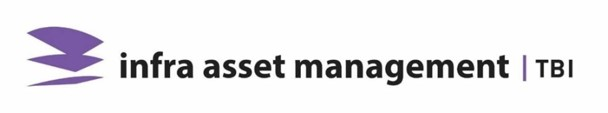

Deze notebook word gebruikt voor het opbouwen an de verschillende grafieken die geëxporteerd moeten worden als PDF om deze bij te voegen als bijlage aan de storingsanalse.

# Importeren van de benodigdheden

## Python packages 

In [93]:
import os
import json
import asyncio

import pandas as pd

import ipywidgets as widgets 
from ipywidgets import interact, interact_manual, Layout

import time
from datetime import datetime

from storingsanalyse import StoringsAnalyse

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.figure import Figure

In [94]:
# Class zorgt ervoor dat een waarde meegegeven kan worden aan een Button
import traitlets
class LoadedButton(widgets.Button):
    """A button that can holds a value as a attribute."""

    def __init__(self, value=None, *args, **kwargs):
        super(LoadedButton, self).__init__(*args, **kwargs)
        # Create the value attribute.
        self.add_traits(value=traitlets.Any(value))


# Aparte functie voor het wachten op verandering (aka input van de ME)
def wait_for_change(widget):
    future = asyncio.Future()
    def getvalue(change):
        future.set_result(change.description)
        widget.on_click(getvalue, remove=True) 
        # we need to free up the binding to getvalue to avoid an InvalidState error
        # buttons don't support unobserve
        # so use `remove=True` 
    widget.on_click(getvalue)
    return future

In [95]:
""" In the line bellow fill in your API key without < and > """ 
api_key = 'bWF4YWRtaW46R21iQ1dlbkQyMDE5' # provided to you by a Maximo Consultant

""" In the line bellow fill in the desired object structure """
obj_struct = 'MXWO_SND' # name of the Maximo object structure

""" In the line bellow fill in the PO number and the SITEID without the < and > """
query = 'siteid="CT1EN2" and worktype="COR" and reportdate>="2018-01-01T00:00:00-00:00" and reportdate<="2018-03-30T00:00:00-00:00"'

In [96]:
sa = StoringsAnalyse("coentunnel", api_key, obj_struct)

In [97]:
sa.metadata.get_all_data()

,project,start_datum,contract_info,meldingen,storingen
0,Coentunnel-tracé,01_2016,"{'tijdsregistratie': 'True', 'minimale_beschik...","{'01_2016': {'45': 6, '61': 5, '23': 1, '43': ...","{'01_2016': {'61': 3, '43': 2, '45': 3, '41': ..."


## Importeren van de staging_file

De staging file geeft ruimte aan de maintenance engineers om de verschillende meldingen te categoriseren als 'Onterecht', 'Preventief', 'Storing' of 'Incident'.

In [98]:
sa.read_staging_file('staging_file.xlsx')

In [99]:
sf_data = sa.staging_file_data

### Aanpassen van de staging_file -- DEZE STAP WORDT VERWIJDERD IN DE TOEKOMST
Het opbouwen van deze automatische storingsanalyse vraagt om een ingevulde kolom 'type melding'. Om het process van opbouwen niet te laten stagneren op dit aspect, wordt er hieronder fictive data gegenereerd. Met behulp van de fictieve data wordt het genereren van de verschillende tabellen en grafieken gebouwd.

In [100]:
from random import randrange

lijst_opties = ['Storing', 'Incident', 'Preventief', 'Onterecht']

random_ranges = [lijst_opties[randrange(0, 4, 1)] for _ in range(len(sf_data['type melding (Storing/Incident/Preventief/Onterecht)']))]

print(len(random_ranges) == len(sf_data['type melding (Storing/Incident/Preventief/Onterecht)']))

sf_data.loc[:, 'type melding (Storing/Incident/Preventief/Onterecht)'] = random_ranges

random_ranges[:10]

True


['Preventief',
 'Preventief',
 'Storing',
 'Onterecht',
 'Onterecht',
 'Incident',
 'Storing',
 'Onterecht',
 'Onterecht',
 'Preventief']

In [101]:
import numpy as np
lijst_opties = ['P01', 'P02', 'P03', 'P04', 'P05', 'P06', 'P07', 'P08', 'P09', 'P10', 'P11', np.nan]

random_ranges = [lijst_opties[randrange(0, len(lijst_opties), 1)] for _ in range(len(sf_data['probleem code']))]

print(len(random_ranges) == len(sf_data['probleem code']))

sf_data.loc[:, 'probleem code'] = random_ranges

random_ranges[:10]

True


['P01', 'P01', 'P07', 'P06', 'P04', 'P11', 'P04', 'P04', nan, 'P05']

In [102]:
lijst_opties = ['C01', 'C02', 'C03', 'C04', 'C05', 'C06', 'C07', 'C08', 'C09', 
                'C10', 'C11', 'C12', 'C13', 'C14', 'C15', 'C16', np.nan]

random_ranges = [lijst_opties[randrange(0, len(lijst_opties), 1)] for _ in range(len(sf_data['oorzaak code']))]

print(len(random_ranges) == len(sf_data['oorzaak code']))

sf_data.loc[:, 'oorzaak code'] = random_ranges

random_ranges[:10]

True


[nan, 'C14', 'C02', 'C03', 'C06', nan, 'C13', 'C02', 'C03', 'C07']

In [103]:
lijst_opties = ['S01', 'S02', 'S03', 'S04', 'S05', 'S06', 'S07', 'S08', np.nan]

random_ranges = [lijst_opties[randrange(0, len(lijst_opties), 1)] for _ in range(len(sf_data['oplos code']))]

print(len(random_ranges) == len(sf_data['oplos code']))

sf_data.loc[:, 'oplos code'] = random_ranges

random_ranges[:10]

True


['S04', 'S01', 'S07', 'S05', 'S06', 'S02', 'S04', 'S08', 'S01', 'S02']

In [104]:
sf_data.iloc[:5, 15:25]

,locatie 2,locatie 2 omschrijving,probleem code,beschrijving probleem,oorzaak code,beschrijving oorzaak,oplos code,oplossing beschrijving,uitgevoerde werkzaamheden,type melding (Storing/Incident/Preventief/Onterecht)
0,NaN,NaN,P01,Lussen vermoedelijk vekeerd om aangesloten,NaN,Davinci,S04,NaN,Storing ontvangen op 4 januari 2018 om 15:28 g...,Preventief
1,NaN,NaN,P01,Intercom installatie niet beschikbaar,C14,NaN,S01,NaN,Storing ontvangen op 6 januari 2018 om 0:23 ge...,Preventief
2,NaN,NaN,P07,Overdruk ruimte pompkelder niet aanwezig,C02,Vorst bewaking,S07,NaN,Storing ontvangen op 6 juniari 2018 om 20:18 g...,Storing
3,NaN,NaN,P06,Geen overdruk aanwezig pompkelders CT1,C03,NaN,S05,NaN,Storing ontvangen op 7 januari 2018 om 7:50 ge...,Onterecht
4,NaN,NaN,P04,Afsluitboom Noord W2 rechts melding niet besch...,C06,NaN,S06,NaN,Storing ontvangen op 8 januari 2018 om 17:10 g...,Onterecht


In [105]:
from prepnplot import PrepNPlot

pp = PrepNPlot()

x = [datetime.strptime(t, '%d-%m-%y %H:%M:%S') for t in sf_data.loc[:, 'rapport datum']]

pp._transform_to_meta_structure(input_object=sf_data,time_key='rapport datum', categorical_key='type melding (Storing/Incident/Preventief/Onterecht)')

{'01_2018': {'Preventief': 6, 'Storing': 9, 'Onterecht': 10, 'Incident': 5},
 '02_2018': {'Onterecht': 13, 'Storing': 8, 'Preventief': 10, 'Incident': 14},
 '03_2018': {'Preventief': 7, 'Onterecht': 9, 'Storing': 3, 'Incident': 5}}

In [106]:
from prepnplot import PrepNPlot

pp = PrepNPlot()

x = [datetime.strptime(t, '%d-%m-%y %H:%M:%S') for t in sf_data.loc[:, 'rapport datum']]

input_object = (sf_data, 'rapport datum', 'type melding (Storing/Incident/Preventief/Onterecht)')

test_step_one = pp._prep_first_step(input_object=input_object,
                                    time_range=[min(x), max(x)],
                                    available_categories=["Storing", "Incident", "Preventief", "Onterecht"]
                                    )

print(f"result 1 = {test_step_one}")

# test_step_two = pp._prep_end_step(input_dict=test_step_one, unique_values=[_ for _ in test_step_one.keys()])
# print(f"result 2 = {test_step_two}")

# tr = [min(x), max(x)]

# test_prep = pp.prep(input_object=sf_data,
#                     categorical_key='type melding (Storing/Incident/Preventief/Onterecht)',
#                     time_key='rapport datum',
#                     time_range=tr,
#                     bin_size='year')

# print(f"result last = {test_prep}")

result 1 = {'01_2018': {'Incident': 5, 'Onterecht': 10, 'Preventief': 6, 'Storing': 9}, '02_2018': {'Incident': 14, 'Onterecht': 13, 'Preventief': 10, 'Storing': 8}, '03_2018': {'Incident': 5, 'Onterecht': 9, 'Preventief': 7, 'Storing': 3}}


# PDF export voorbereiden

De voorbereiding van de export naar PDF bestaat uit het definieren van een object waarin de verschillende figures toegevoegd kunnen worden.

In [107]:
graphs = []
def add_graph_for_export(figure: Figure):
    global graphs
    graphs.append(figure)

# Grafieken
het opbouwen van de vershcillende grafiek wordt gedaan in twee codeblokken; een prep blok en een plot blok. prep doelt hier op het voorberijden van de data en plot zegt het al.

In [108]:
sa.split_staging_file()

'Data available through the use of StoringsAnalyse.meldingen and StoringsAnalyse.storingen'

## Aantal meldingen per deelinstallatie

In [109]:
df = sf_data.copy()
# changing the di_numbers from '45-10' to '45'
new_num = []
for num in df['sbs']:
    if num is np.nan:
        new_num.append(num)
    else:
        new_num.append(sa._isolate_di_number(num))ss

df.loc[:, 'sbs'] = new_num

In [110]:
# prep
sbs_grouped_df = df.copy().groupby(['sbs'])

"""
dictionary structure
{'23': {1: 1},
 '41': {1: 1},
 '43': {2: 1},
 '45': {2: 2, 1: 2},
 '46A': {2: 2},
 '61': {3: 1},
 '62': {1: 1},
 '63': {1: 1},
 '67': {2: 1},
 '74': {2: 1}}
"""
dictionary = {}
for group in sbs_grouped_df.groups.keys():
    df_group = sbs_grouped_df.get_group(group)
    month_counts = df_group['month_number'].value_counts().to_dict()
    if group in dictionary:
        for key in group.keys():
            if key in dictionary[group]:
                dictionary[group][key] += group[key]
            else:
                dictionary[group] = group[key]
    else:
        dictionary[group] = month_counts

"""
new_dictionary structure
{'23': [1, 0, 0],
 '41': [1, 0, 0],
 '43': [0, 1, 0],
 '45': [2, 2, 0],
 '46A': [0, 2, 0],
 '61': [0, 0, 1],
 '62': [1, 0, 0],
 '63': [1, 0, 0],
 '67': [0, 1, 0],
 '74': [0, 1, 0]}
"""
new_dictionary = {}
for di_num in dictionary:
    list_of_lists = []
    for i in range(3):
        month_num = i + 1
        if month_num in dictionary[di_num].keys():
            list_of_lists.append(dictionary[di_num][month_num])
        else:
            list_of_lists.append(0)
    new_dictionary[di_num] = list_of_lists

"""
lol structure
[[1, 1, 0, 2, 0, 0, 1, 1, 0, 0],
 [0, 0, 1, 2, 2, 0, 0, 0, 1, 1],
 [0, 0, 0, 0, 0, 1, 0, 0, 0, 0]]
"""
lol = []  # list of lists but name was already used
for index in range(3):
    l = []
    for di_num in new_dictionary:
        l.append(new_dictionary[di_num][index])
    lol.append(l)

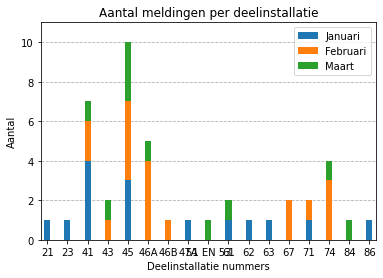

In [111]:
# plot
labels = list(new_dictionary.keys())
width = 0.3

fig, axis = plt.subplots()

prev = []
for l in range(len(lol)):
    month = sa._month_num_to_name([l+1])

    # added case for loop l = 0 after if
    axis.bar(labels, lol[l], width, label=month, bottom=prev) if l > 0 else \
    axis.bar(labels, lol[l], width, label=month)
    
    # prev sets the height of the newly added values like above
    # the added list needs to be added to prev to get the correct height
    prev = [prev[idx] + lol[l][idx] for idx in range(len(lol[l]))] if l > 0 else lol[l]

axis.set_xlabel('Deelinstallatie nummers')
axis.set_ylabel('Aantal')
axis.set_title("Aantal meldingen per deelinstallatie")
axis.legend()

axis.margins(x=0.01, y=0.1)

axis.set_axisbelow(True)
axis.grid(axis='y', linestyle='--')

plt.show()
add_graph_for_export(fig)

{'Januari': 30, 'Februari': 45, 'Maart': 24}


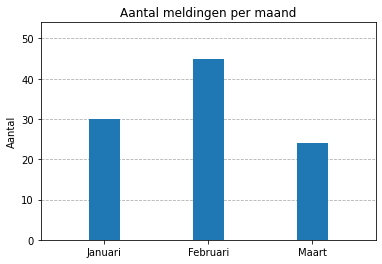

In [112]:
# prep
val_counts_months = df['month_number'].value_counts()

ordered_dict = {key: val_counts_months[key] for key in sorted(val_counts_months.to_dict())}

for key in ordered_dict.keys():
    new_key = sa._month_num_to_name([key])
    ordered_dict[new_key] = ordered_dict.pop(key)

print(ordered_dict)

# plot
fig, axis = plt.subplots()
axis.bar(ordered_dict.keys(), ordered_dict.values(), width = 0.3)
axis.set_ylabel('Aantal')
axis.set_title("Aantal meldingen per maand")
axis.margins(x=.2, y=.2)

axis.set_axisbelow(True)
axis.grid(axis='y', linestyle='--')

plt.show()
add_graph_for_export(fig)

### Using PrepNPlot

01_2018 nan pop. count = 15
02_2018 nan pop. count = 27
03_2018 nan pop. count = 14


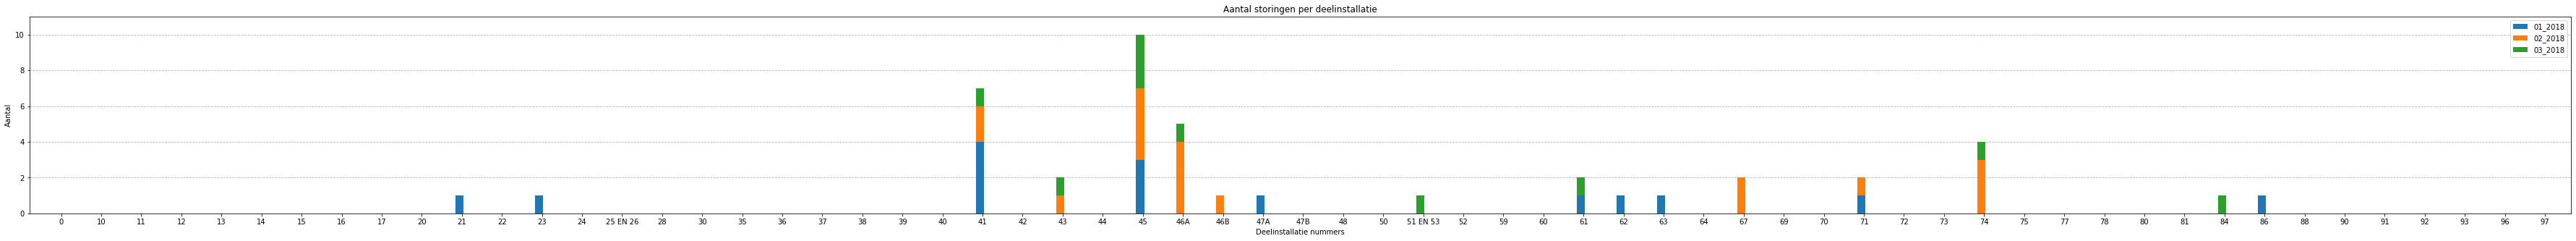

In [113]:
input_data = (df, 'rapport datum', 'sbs')
time_range = [min(df['rapport datum']), max(df['rapport datum'])]
available_categories = sa.metadata.contract_info()['aanwezige_deelinstallaties']

prepped_data = pp.prep(df, time_range, available_categories, time_key='rapport datum', category_key='sbs')

plot_type = 'stacked'
category_labels = available_categories.copy()
# needed to cover 'nan', else ValueError: shape mismatch: objects cannot be broadcast to a single shape

pp.plot(input_data=prepped_data, plot_type='stacked', category_labels=category_labels, bin_labels=pp.last_seen_bin_names)

01_2018 nan pop. count = 15
02_2018 nan pop. count = 27
03_2018 nan pop. count = 14


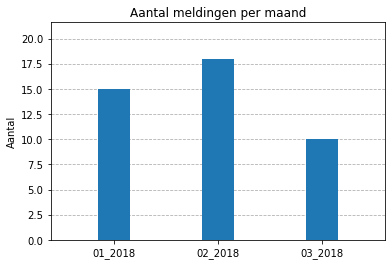

In [114]:
summary_data = pp.prep_summary(df, time_range, available_categories, time_key='rapport datum', category_key='sbs')
pp.plot_summary(input_data=summary_data)


## Aantal storingen per deelinstallatie

In [115]:
df_s = sa.storingen.copy()
# changing the di_numbers from '45-10' to '45'
new_num = []
for num in df_s['sbs']:
    if num is np.nan:
        new_num.append(num)
    else:
        new_num.append(sa._isolate_di_number(num))

df_s.loc[:, 'sbs'] = new_num

In [116]:
# prep
sbs_grouped_df = df_s.copy().groupby(['sbs'])

"""
dictionary structure
{'23': {1: 1},
 '41': {1: 1},
 '43': {2: 1},
 '45': {2: 2, 1: 2},
 '46A': {2: 2},
 '61': {3: 1},
 '62': {1: 1},
 '63': {1: 1},
 '67': {2: 1},
 '74': {2: 1}}
"""
dictionary = {}
for group in sbs_grouped_df.groups.keys():
    df_group = sbs_grouped_df.get_group(group)
    month_counts = df_group['month_number'].value_counts().to_dict()
    if group in dictionary:
        for key in group.keys():
            if key in dictionary[group]:
                dictionary[group][key] += group[key]
            else:
                dictionary[group] = group[key]
    else:
        dictionary[group] = month_counts

"""
new_dictionary structure
{'23': [1, 0, 0],
 '41': [1, 0, 0],
 '43': [0, 1, 0],
 '45': [2, 2, 0],
 '46A': [0, 2, 0],
 '61': [0, 0, 1],
 '62': [1, 0, 0],
 '63': [1, 0, 0],
 '67': [0, 1, 0],
 '74': [0, 1, 0]}
"""
new_dictionary = {}
for di_num in dictionary:
    list_of_lists = []
    for i in range(3):
        month_num = i + 1
        if month_num in dictionary[di_num].keys():
            list_of_lists.append(dictionary[di_num][month_num])
        else:
            list_of_lists.append(0)
    new_dictionary[di_num] = list_of_lists

"""
lol structure
[[1, 1, 0, 2, 0, 0, 1, 1, 0, 0],
 [0, 0, 1, 2, 2, 0, 0, 0, 1, 1],
 [0, 0, 0, 0, 0, 1, 0, 0, 0, 0]]
"""
lol = []  # list of lists but name was already used
for index in range(3):
    l = []
    for di_num in new_dictionary:
        l.append(new_dictionary[di_num][index])
    lol.append(l)

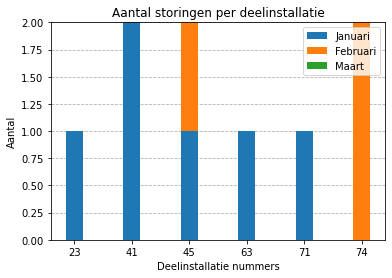

In [117]:
# plot
labels = list(new_dictionary.keys())
width = 0.3

fig, axis = plt.subplots()

prev = []
for l in range(len(lol)):
    month = sa._month_num_to_name([l+1])

    # added case for loop l = 0 after if
    axis.bar(labels, lol[l], width, label=month, bottom=prev) if l > 0 else \
    axis.bar(labels, lol[l], width, label=month)
    
    # prev sets the height of the newly added values like above
    # the added list needs to be added to prev to get the correct height
    prev = [prev[idx] + lol[l][idx] for idx in range(len(lol[l]))] if l > 0 else lol[l]

axis.set_xlabel('Deelinstallatie nummers')
axis.set_ylabel('Aantal')
axis.set_title("Aantal storingen per deelinstallatie")
axis.legend()

axis.margins(x=0.05, y=0.1)

axis.set_axisbelow(True)
axis.grid(axis='y', linestyle='--')

plt.show()
add_graph_for_export(fig)

{'Januari': 9, 'Februari': 8, 'Maart': 3}


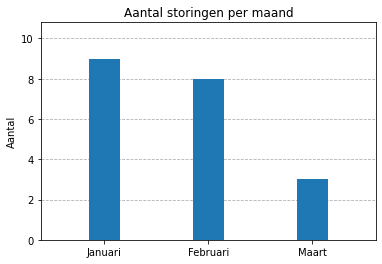

In [118]:
# prep
val_counts_months = df_s['month_number'].value_counts()

ordered_dict = {key: val_counts_months[key] for key in sorted(val_counts_months.to_dict())}

for key in ordered_dict.keys():
    new_key = sa._month_num_to_name([key])
    ordered_dict[new_key] = ordered_dict.pop(key)

print(ordered_dict)    
    
# plot
fig, axis = plt.subplots()
axis.bar(ordered_dict.keys(), ordered_dict.values(), width = 0.3)
axis.set_ylabel('Aantal')
axis.set_title("Aantal storingen per maand")
axis.margins(x=.2, y=.2)

axis.set_axisbelow(True)
axis.grid(axis='y', linestyle='--')

plt.show()
add_graph_for_export(fig)

### Using PrepNPlot

01_2018 nan pop. count = 3
02_2018 nan pop. count = 5
03_2018 nan pop. count = 3


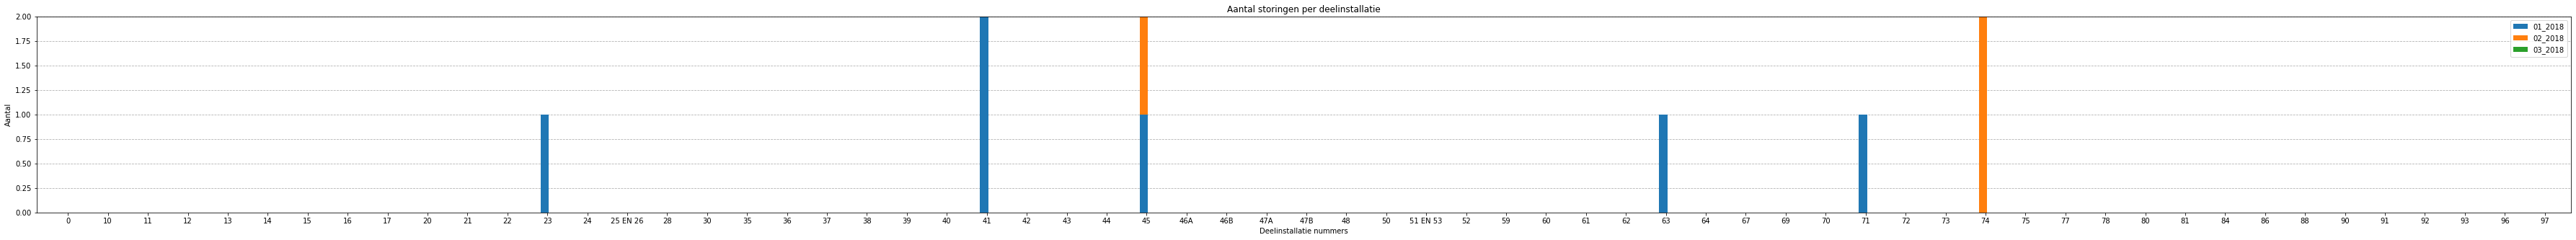

In [119]:
input_data = (df_s, 'rapport datum', 'sbs')
time_range = [min(df['rapport datum']), max(df['rapport datum'])]
available_categories = sa.metadata.contract_info()['aanwezige_deelinstallaties']

prepped_data = pp.prep(df_s, time_range, available_categories, time_key='rapport datum', category_key='sbs')

plot_type = 'stacked'
category_labels = available_categories.copy()
# needed to cover 'nan', else ValueError: shape mismatch: objects cannot be broadcast to a single shape

pp.plot(input_data=prepped_data, plot_type='stacked', category_labels=category_labels, bin_labels=pp.last_seen_bin_names)

In [ ]:
summary_data = pp.prep_summary(df_s, time_range, available_categories, time_key='rapport datum', category_key='sbs')
pp.plot_summary(input_data=summary_data)


## Aantal onterechte meldingen per deelinstallatie

In [120]:
df_o = sa._isolate_notification_type(like_ntype='onterecht').copy()
# changing the di_numbers from '45-10' to '45'
new_num = []
for num in df_o['sbs']:
    if num is np.nan:
        new_num.append(num)
    else:
        new_num.append(sa._isolate_di_number(num))

df_o.loc[:, 'sbs'] = new_num

In [121]:
# prep
sbs_grouped_df = df_o.copy().groupby(['sbs'])

"""
dictionary structure
{'23': {1: 1},
 '41': {1: 1},
 '43': {2: 1},
 '45': {2: 2, 1: 2},
 '46A': {2: 2},
 '61': {3: 1},
 '62': {1: 1},
 '63': {1: 1},
 '67': {2: 1},
 '74': {2: 1}}
"""
dictionary = {}
for group in sbs_grouped_df.groups.keys():
    df_group = sbs_grouped_df.get_group(group)
    month_counts = df_group['month_number'].value_counts().to_dict()
    if group in dictionary:
        for key in group.keys():
            if key in dictionary[group]:
                dictionary[group][key] += group[key]
            else:
                dictionary[group] = group[key]
    else:
        dictionary[group] = month_counts

"""
new_dictionary structure
{'23': [1, 0, 0],
 '41': [1, 0, 0],
 '43': [0, 1, 0],
 '45': [2, 2, 0],
 '46A': [0, 2, 0],
 '61': [0, 0, 1],
 '62': [1, 0, 0],
 '63': [1, 0, 0],
 '67': [0, 1, 0],
 '74': [0, 1, 0]}
"""
new_dictionary = {}
for di_num in dictionary:
    list_of_lists = []
    for i in range(3):
        month_num = i + 1
        if month_num in dictionary[di_num].keys():
            list_of_lists.append(dictionary[di_num][month_num])
        else:
            list_of_lists.append(0)
    new_dictionary[di_num] = list_of_lists

"""
lol structure
[[1, 1, 0, 2, 0, 0, 1, 1, 0, 0],
 [0, 0, 1, 2, 2, 0, 0, 0, 1, 1],
 [0, 0, 0, 0, 0, 1, 0, 0, 0, 0]]
"""
lol = []  # list of lists but name was already used
for index in range(3):
    l = []
    for di_num in new_dictionary:
        l.append(new_dictionary[di_num][index])
    lol.append(l)

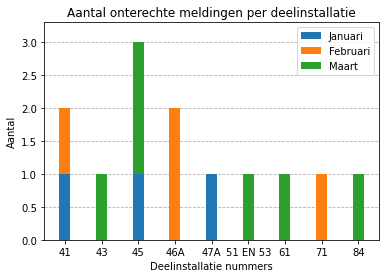

In [122]:
# plot
labels = list(new_dictionary.keys())
width = 0.3

fig, axis = plt.subplots()

prev = []
for l in range(len(lol)):
    month = sa._month_num_to_name([l+1])

    # added case for loop l = 0 after if
    axis.bar(labels, lol[l], width, label=month, bottom=prev) if l > 0 else \
    axis.bar(labels, lol[l], width, label=month)
    
    # prev sets the height of the newly added values like above
    # the added list needs to be added to prev to get the correct height
    prev = [prev[idx] + lol[l][idx] for idx in range(len(lol[l]))] if l > 0 else lol[l]

axis.set_xlabel('Deelinstallatie nummers')
axis.set_ylabel('Aantal')
axis.set_title("Aantal onterechte meldingen per deelinstallatie")
axis.legend()

axis.margins(x=0.05, y=0.1)

axis.set_axisbelow(True)
axis.grid(axis='y', linestyle='--')

plt.show()
add_graph_for_export(fig)

{'Januari': 10, 'Februari': 13, 'Maart': 9}


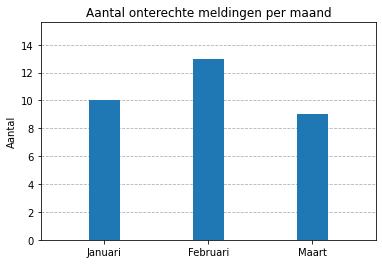

In [123]:
# prep
val_counts_months = df_o['month_number'].value_counts()

ordered_dict = {key: val_counts_months[key] for key in sorted(val_counts_months.to_dict())}

for key in ordered_dict.keys():
    new_key = sa._month_num_to_name([key])
    ordered_dict[new_key] = ordered_dict.pop(key)

print(ordered_dict)
    
# plot
fig, axis = plt.subplots()
axis.bar(ordered_dict.keys(), ordered_dict.values(), width = 0.3)
axis.set_ylabel('Aantal')
axis.set_title("Aantal onterechte meldingen per maand")
axis.margins(x=.2, y=.2)

axis.set_axisbelow(True)
axis.grid(axis='y', linestyle='--')

plt.show()
add_graph_for_export(fig)

### Using PrepNPlot

01_2018 nan pop. count = 7
02_2018 nan pop. count = 9
03_2018 nan pop. count = 3


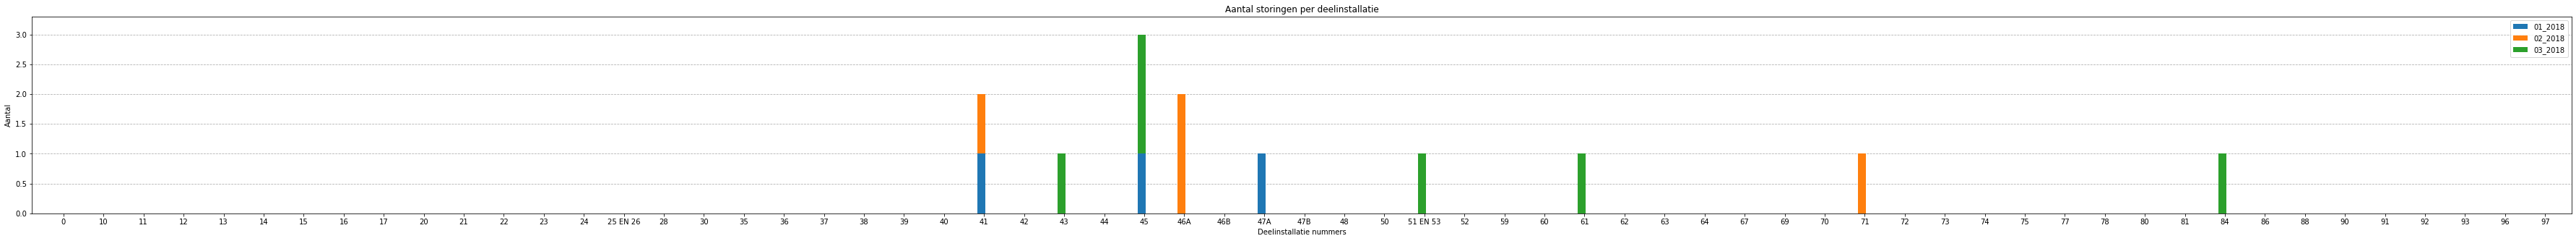

In [124]:
input_data = (df_o, 'rapport datum', 'sbs')
time_range = [min(df['rapport datum']), max(df['rapport datum'])]
available_categories = sa.metadata.contract_info()['aanwezige_deelinstallaties']

prepped_data = pp.prep(df_o, time_range, available_categories, time_key='rapport datum', category_key='sbs')

plot_type = 'stacked'
category_labels = available_categories.copy()
# needed to cover 'nan', else ValueError: shape mismatch: objects cannot be broadcast to a single shape

pp.plot(input_data=prepped_data, plot_type='stacked', category_labels=category_labels, bin_labels=pp.last_seen_bin_names)

In [ ]:
summary_data = pp.prep_summary(df_o, time_range, available_categories, time_key='rapport datum', category_key='sbs')
pp.plot_summary(input_data=summary_data)


## Totaal aantal meldingen preventief per deelinstallatie

In [125]:
df_p = sa._isolate_notification_type(like_ntype='preventief').copy()
# changing the di_numbers from '45-10' to '45'
new_num = []
for num in df_p['sbs']:
    if num is np.nan:
        new_num.append(num)
    else:
        new_num.append(sa._isolate_di_number(num))

df_p.loc[:, 'sbs'] = new_num

In [126]:
# prep
sbs_grouped_df = df_p.copy().groupby(['sbs'])

"""
dictionary structure
{'23': {1: 1},
 '41': {1: 1},
 '43': {2: 1},
 '45': {2: 2, 1: 2},
 '46A': {2: 2},
 '61': {3: 1},
 '62': {1: 1},
 '63': {1: 1},
 '67': {2: 1},
 '74': {2: 1}}
"""
dictionary = {}
for group in sbs_grouped_df.groups.keys():
    df_group = sbs_grouped_df.get_group(group)
    month_counts = df_group['month_number'].value_counts().to_dict()
    if group in dictionary:
        for key in group.keys():
            if key in dictionary[group]:
                dictionary[group][key] += group[key]
            else:
                dictionary[group] = group[key]
    else:
        dictionary[group] = month_counts

"""
new_dictionary structure
{'23': [1, 0, 0],
 '41': [1, 0, 0],
 '43': [0, 1, 0],
 '45': [2, 2, 0],
 '46A': [0, 2, 0],
 '61': [0, 0, 1],
 '62': [1, 0, 0],
 '63': [1, 0, 0],
 '67': [0, 1, 0],
 '74': [0, 1, 0]}
"""
new_dictionary = {}
for di_num in dictionary:
    list_of_lists = []
    for i in range(3):
        month_num = i + 1
        if month_num in dictionary[di_num].keys():
            list_of_lists.append(dictionary[di_num][month_num])
        else:
            list_of_lists.append(0)
    new_dictionary[di_num] = list_of_lists

"""
lol structure
[[1, 1, 0, 2, 0, 0, 1, 1, 0, 0],
 [0, 0, 1, 2, 2, 0, 0, 0, 1, 1],
 [0, 0, 0, 0, 0, 1, 0, 0, 0, 0]]
"""
lol = []  # list of lists but name was already used
for index in range(3):
    l = []
    for di_num in new_dictionary:
        l.append(new_dictionary[di_num][index])
    lol.append(l)

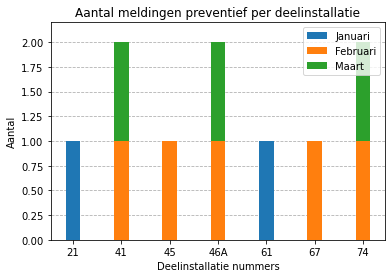

In [127]:
# plot
labels = list(new_dictionary.keys())
width = 0.3

fig, axis = plt.subplots()

prev = []
for l in range(len(lol)):
    month = sa._month_num_to_name([l+1])

    # added case for loop l = 0 after if
    axis.bar(labels, lol[l], width, label=month, bottom=prev) if l > 0 else \
    axis.bar(labels, lol[l], width, label=month)
    
    # prev sets the height of the newly added values like above
    # the added list needs to be added to prev to get the correct height
    prev = [prev[idx] + lol[l][idx] for idx in range(len(lol[l]))] if l > 0 else lol[l]


axis.set_xlabel('Deelinstallatie nummers')
axis.set_ylabel('Aantal')
axis.set_title("Aantal meldingen preventief per deelinstallatie")
axis.legend()

axis.margins(x=0.05, y=0.1)

axis.set_axisbelow(True)
axis.grid(axis='y', linestyle='--')

plt.show()
add_graph_for_export(fig)

{'Januari': 6, 'Februari': 10, 'Maart': 7}


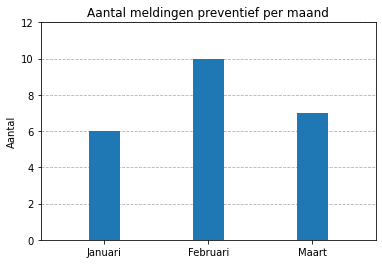

In [128]:
# prep
val_counts_months = df_p['month_number'].value_counts()

ordered_dict = {key: val_counts_months[key] for key in sorted(val_counts_months.to_dict())}

for key in ordered_dict.keys():
    new_key = sa._month_num_to_name([key])
    ordered_dict[new_key] = ordered_dict.pop(key)

print(ordered_dict)
    
# plot
fig, axis = plt.subplots()
axis.bar(ordered_dict.keys(), ordered_dict.values(), width = 0.3)
axis.set_ylabel('Aantal')
axis.set_title("Aantal meldingen preventief per maand")
axis.margins(x=.2, y=.2)

axis.set_axisbelow(True)
axis.grid(axis='y', linestyle='--')

plt.show()
add_graph_for_export(fig)

### Using PrepNPlot

01_2018 nan pop. count = 4
02_2018 nan pop. count = 5
03_2018 nan pop. count = 4


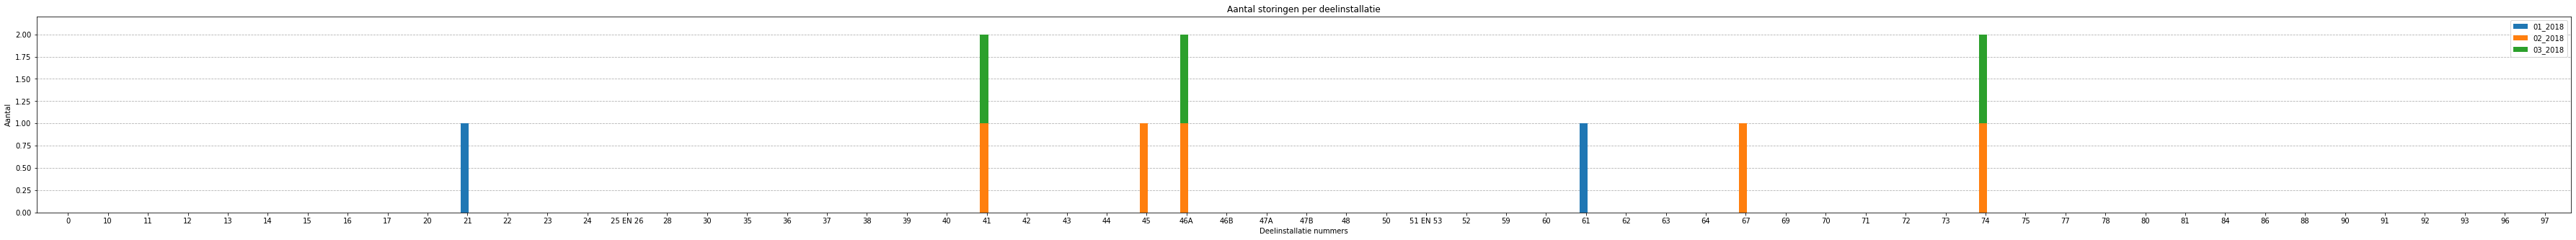

In [129]:
input_data = (df_p, 'rapport datum', 'sbs')
time_range = [min(df['rapport datum']), max(df['rapport datum'])]
available_categories = sa.metadata.contract_info()['aanwezige_deelinstallaties']

prepped_data = pp.prep(df_p, time_range, available_categories, time_key='rapport datum', category_key='sbs')

plot_type = 'stacked'
category_labels = available_categories.copy()
# needed to cover 'nan', else ValueError: shape mismatch: objects cannot be broadcast to a single shape

pp.plot(input_data=prepped_data, plot_type='stacked', category_labels=category_labels, bin_labels=pp.last_seen_bin_names)

In [ ]:
summary_data = pp.prep_summary(df_p, time_range, available_categories, time_key='rapport datum', category_key='sbs')
pp.plot_summary(input_data=summary_data)


## Aantal incidenten per deelinstallatie

In [130]:
df_i = sa._isolate_notification_type(like_ntype='incident').copy()
# changing the di_numbers from '45-10' to '45'
new_num = []
for num in df_i['sbs']:
    if num is np.nan:
        new_num.append(num)
    else:
        new_num.append(sa._isolate_di_number(num))

df_i.loc[:, 'sbs'] = new_num

In [131]:
# prep
sbs_grouped_df = df_i.copy().groupby(['sbs'])

"""
dictionary structure (result of code below)
{'23': {1: 1},  # {month_num: notifications}
 '41': {1: 1},
 '43': {2: 1},
 '45': {2: 2, 1: 2},
 '46A': {2: 2},
 '61': {3: 1},
 '62': {1: 1},
 '63': {1: 1},
 '67': {2: 1},
 '74': {2: 1}}
"""
dictionary = {}
for group in sbs_grouped_df.groups.keys():
    df_group = sbs_grouped_df.get_group(group)
    month_counts = df_group['month_number'].value_counts().to_dict()
    if group in dictionary:
        for key in group.keys():
            if key in dictionary[group]:
                dictionary[group][key] += group[key]
            else:
                dictionary[group] = group[key]
    else:
        dictionary[group] = month_counts

"""
new_dictionary structure (result of code below)
{'23': [1, 0, 0],
 '41': [1, 0, 0],
 '43': [0, 1, 0],
 '45': [2, 2, 0],
 '46A': [0, 2, 0],
 '61': [0, 0, 1],
 '62': [1, 0, 0],
 '63': [1, 0, 0],
 '67': [0, 1, 0],
 '74': [0, 1, 0]}
"""
new_dictionary = {}
for di_num in dictionary:
    list_of_lists = []
    for i in range(3):
        month_num = i + 1
        if month_num in dictionary[di_num].keys():
            list_of_lists.append(dictionary[di_num][month_num])
        else:
            list_of_lists.append(0)
    new_dictionary[di_num] = list_of_lists

"""
lol structure (result of code below)
[[1, 1, 0, 2, 0, 0, 1, 1, 0, 0],
 [0, 0, 1, 2, 2, 0, 0, 0, 1, 1],
 [0, 0, 0, 0, 0, 1, 0, 0, 0, 0]]
"""
lol = []  # list of lists but name was already used
for index in range(3):
    l = []
    for di_num in new_dictionary:
        l.append(new_dictionary[di_num][index])
    lol.append(l)

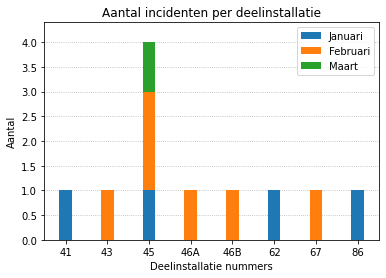

In [132]:
# plot
labels = list(new_dictionary.keys())
width = 0.3

fig, axis = plt.subplots()

prev = []
for l in range(len(lol)):
    month = sa._month_num_to_name([l+1])

    # added case for loop l = 0 after if
    axis.bar(labels, lol[l], width, label=month, bottom=prev) if l > 0 else \
    axis.bar(labels, lol[l], width, label=month)
    
    # prev sets the height of the newly added values like above
    # the added list needs to be added to prev to get the correct height
    prev = [prev[idx] + lol[l][idx] for idx in range(len(lol[l]))] if l > 0 else lol[l]


axis.set_xlabel('Deelinstallatie nummers')
axis.set_ylabel('Aantal')
axis.set_title("Aantal incidenten per deelinstallatie")
axis.legend()

axis.margins(x=0.05, y=0.1)

axis.set_axisbelow(True)
axis.grid(axis='y', linestyle=':')

plt.show()
add_graph_for_export(fig)

{'Januari': 5, 'Februari': 14, 'Maart': 5}


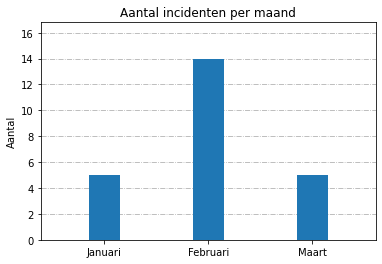

In [133]:
# prep
val_counts_months = df_i['month_number'].value_counts()

ordered_dict = {key: val_counts_months[key] for key in sorted(val_counts_months.to_dict())}

for key in ordered_dict.keys():
    new_key = sa._month_num_to_name([key])
    ordered_dict[new_key] = ordered_dict.pop(key)

print(ordered_dict)    
    
# plot
fig, axis = plt.subplots()
axis.bar(ordered_dict.keys(), ordered_dict.values(), width = 0.3)
axis.set_ylabel('Aantal')
axis.set_title("Aantal incidenten per maand")
axis.margins(x=.2, y=.2)

axis.set_axisbelow(True)
axis.grid(axis='y', linestyle='-.')

plt.show()
add_graph_for_export(fig)

### Using PrepNPlot

01_2018 nan pop. count = 1
02_2018 nan pop. count = 8
03_2018 nan pop. count = 4


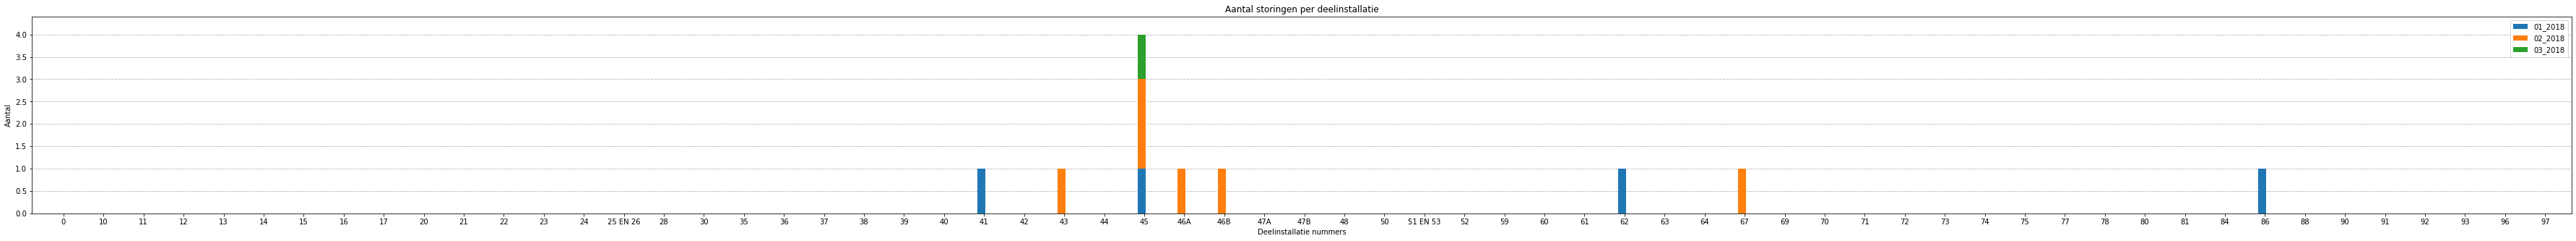

In [134]:
input_data = (df_i, 'rapport datum', 'sbs')
time_range = [min(df['rapport datum']), max(df['rapport datum'])]
available_categories = sa.metadata.contract_info()['aanwezige_deelinstallaties']

prepped_data = pp.prep(df_i, 
                       time_range, 
                       available_categories, 
                       time_key='rapport datum', 
                       category_key='sbs')

plot_type = 'stacked'
category_labels = available_categories.copy()

pp.plot(input_data=prepped_data, plot_type='stacked', category_labels=category_labels, bin_labels=pp.last_seen_bin_names)

01_2018 nan pop. count = 1
02_2018 nan pop. count = 8
03_2018 nan pop. count = 4


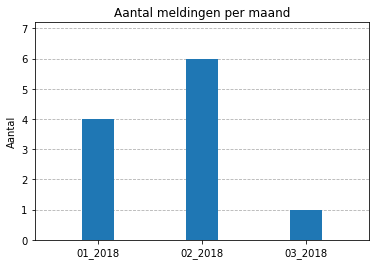

In [194]:
summary_data = pp.prep_summary(df_i, 
                               time_range, 
                               available_categories, 
                               time_key='rapport datum', 
                               category_key='sbs')

pp.plot_summary(input_data=summary_data)

# Combineren van de historische data met de staging file.

In [135]:
# meldingen
x = sa.meldingen.copy()
histo_meldingen = sa.metadata.meldingen()

# datum wordt een input veld
input_start_date = datetime(2021, 4, 1)

new_num = []
for num in x['sbs']:
    if num is np.nan:
        new_num.append(num)
    else:
        new_num.append(sa._isolate_di_number(num))

x.loc[:, 'sbs'] = new_num

x = x.groupby(['month_number'])

"""
De meldnigen zonder di nummer worden door Remko nu anagepast zodat ze toch een di nummer hebben.
"""
new_hist = {}
for group in x.groups:
    dff = x.get_group(group)
    vc = dff['sbs'].value_counts().to_dict()
    key = f'0{group}_{input_start_date.year}' if group < 10 else f'{group}_{input_start_date.year}'
    new_hist[key] = dff['sbs'].value_counts().to_dict()
    

# dev_case had historical data up until 03_2021, so TypeError because of overlapping keys Q1 for 2021
# updated_histo = dict(**histo_meldingen, **new_hist)
updated_histo = dict(**histo_meldingen)

In [136]:
# storingen
x = sa.storingen.copy()
histo_storingen = sa.metadata.storingen()

new_num = []
for num in x['sbs']:
    if num is np.nan:
        new_num.append(num)
    else:
        new_num.append(sa._isolate_di_number(num))

x.loc[:, 'sbs'] = new_num

x = x.groupby(['month_number'])

new_hist = {}
for group in x.groups:
    dff = x.get_group(group)
    vc = dff['sbs'].value_counts().to_dict()
    key = f'0{group}_{input_start_date.year}' if group < 10 else f'{group}_{input_start_date.year}'
    new_hist[key] = dff['sbs'].value_counts().to_dict()
    

# dev_case had historical data up until 03_2021, so TypeError because of overlapping keys Q1 for 2021
# updated_histo = dict(**histo_storingen, **new_hist)
updated_histo_storingen = dict(**histo_storingen)

# Vervolg grafieken

## Vergelijking meldingen Qx met alle voorgaande Qx

In [137]:
months_to_exclude = [sa.metadata._quarters[q][i] for q in sa.metadata._quarters.keys() if q != 'Q1' for i in range(len(sa.metadata._quarters[q]))]
print(f'Months to exclude in function get_month_list: {months_to_exclude}\n')

month_list = sa.metadata.get_month_list(exclude_month=months_to_exclude)
print(f'month list = {month_list}')

ordered_month_list = sa.metadata.order_month_list_by_year(month_list=month_list)
ordered_month_list


Months to exclude in function get_month_list: ['04', '05', '06', '07', '08', '09', '10', '11', '12']

month list = ['01_2016', '02_2016', '03_2016', '01_2017', '02_2017', '03_2017', '01_2018', '02_2018', '03_2018', '01_2019', '02_2019', '03_2019', '01_2020', '02_2020', '03_2020', '01_2021', '02_2021', '03_2021']


{'2016': ['01_2016', '02_2016', '03_2016'],
 '2017': ['01_2017', '02_2017', '03_2017'],
 '2018': ['01_2018', '02_2018', '03_2018'],
 '2019': ['01_2019', '02_2019', '03_2019'],
 '2020': ['01_2020', '02_2020', '03_2020'],
 '2021': ['01_2021', '02_2021', '03_2021']}

Neem de ordered dict en verzamel de som van de meldingen per maand en som die per jaar op. result is een dict met structuur
```
{q1_jaar1: aantal meldingen,
 ... : ... ,
 q1_jaarn: aantal meldingen}
```

In [138]:
notifications_per_quarter = {}
for key in ordered_month_list.keys():
    summed_vals = sa.metadata.sum_values(dictionary=updated_histo, keys=ordered_month_list[key])
    notifications_per_quarter[key] = summed_vals

notifications_per_quarter

{'2016': 184, '2017': 122, '2018': 100, '2019': 71, '2020': 60, '2021': 158}

### Alternatieve werkwijze
Met het toepassen van de module self.filter_dictionary_keys().

werkwijze van hiervoor verzameld eerst het aantal meldingen per kwartaal en dan meldingen per deelinstallatie per kwartaal.

onderstaande werkwijze verzameld eerst het aantal meldingen per di per kwartaal en dan het aantal meldingen per kwartaal.

In [139]:
filtered_meldingen_dict = {}
for key in ordered_month_list.keys():
    filtered_meldingen = sa.metadata.filter_dictionary_keys(dictionary=updated_histo, keys=ordered_month_list[key])
    filtered_meldingen_dict[key] = filtered_meldingen
    
filtered_meldingen_dict

{'2016': {'01_2016': {'45': 6,
   '61': 5,
   '23': 1,
   '43': 4,
   '41': 3,
   '46B': 3,
   '46A': 1,
   '44': 2,
   '97': 1,
   '21': 1,
   '48': 1,
   '15': 6,
   '74': 2,
   '36': 2,
   '59': 1,
   '50': 5,
   '67': 1,
   '40': 1,
   '90': 1,
   '92': 1},
  '02_2016': {'45': 19,
   '61': 4,
   '23': 13,
   '63': 4,
   '43': 1,
   '41': 7,
   '0': 3,
   '46B': 1,
   '46A': 1,
   '44': 7,
   '24': 1,
   '97': 1,
   '71': 8,
   '15': 6,
   '64': 1,
   '50': 2,
   '75': 1,
   '12': 1},
  '03_2016': {'45': 10,
   '61': 8,
   '63': 2,
   '43': 12,
   '41': 1,
   '0': 4,
   '46B': 1,
   '46A': 7,
   '24': 2,
   '21': 1,
   '71': 1,
   '86': 1,
   '64': 2,
   '59': 1,
   '67': 1,
   '80': 1}},
 '2017': {'01_2017': {'45': 15,
   '61': 14,
   '63': 3,
   '43': 2,
   '0': 3,
   '24': 1,
   '71': 1,
   '48': 3,
   '62': 1,
   '74': 1,
   '59': 1,
   '72': 1,
   '73': 1,
   '75': 2,
   '47B': 2,
   '11': 1},
  '02_2017': {'45': 4,
   '61': 8,
   '63': 2,
   '41': 3,
   '0': 1,
   '46B': 3,
  

## Vervolg Vergelijking Qx met alle voorgaande Qx

In [140]:
melding_per_q_dict = {}
for year in filtered_meldingen_dict:  # keys als '2016', '2021'
    if year not in melding_per_q_dict.keys():  # add key to new dict
        melding_per_q_dict[year] = {}
    
    for d in filtered_meldingen_dict[year]:  # keys als '01_2016', '02_2016'
        for di in filtered_meldingen_dict[year][d]:  # keys als di_nummers '45', '61'
            if di not in melding_per_q_dict[year].keys():
                melding_per_q_dict[year][di] = filtered_meldingen_dict[year][d][di]
            else:
                melding_per_q_dict[year][di] += filtered_meldingen_dict[year][d][di]
                
melding_per_q_dict  # wordt gebruikt om bars van bar plot naast elkaar te plotten

{'2016': {'45': 35,
  '61': 17,
  '23': 14,
  '43': 17,
  '41': 11,
  '46B': 5,
  '46A': 9,
  '44': 9,
  '97': 2,
  '21': 2,
  '48': 1,
  '15': 12,
  '74': 2,
  '36': 2,
  '59': 2,
  '50': 7,
  '67': 2,
  '40': 1,
  '90': 1,
  '92': 1,
  '63': 6,
  '0': 7,
  '24': 3,
  '71': 9,
  '64': 3,
  '75': 1,
  '12': 1,
  '86': 1,
  '80': 1},
 '2017': {'45': 25,
  '61': 28,
  '63': 8,
  '43': 7,
  '0': 8,
  '24': 1,
  '71': 1,
  '48': 4,
  '62': 2,
  '74': 2,
  '59': 1,
  '72': 1,
  '73': 1,
  '75': 2,
  '47B': 2,
  '11': 1,
  '41': 8,
  '46B': 3,
  '44': 1,
  '47A': 1,
  '15': 1,
  '30': 1,
  '88': 3,
  '86': 4,
  '64': 2,
  '84': 2,
  '38': 1,
  '39': 1},
 '2018': {'45': 11,
  '61': 10,
  '23': 8,
  '63': 8,
  '43': 10,
  '41': 8,
  '0': 12,
  '21': 1,
  '71': 2,
  '47A': 1,
  '86': 3,
  '62': 4,
  '88': 1,
  '38': 5,
  '46B': 1,
  '46A': 5,
  '74': 4,
  '67': 2,
  '48': 1,
  '64': 1,
  '84': 1,
  '51 EN 53': 1},
 '2019': {'45': 7,
  '61': 12,
  '63': 7,
  '43': 6,
  '41': 5,
  '46B': 3,
  '46

In [141]:
# switching level 1 and level 2 keys
present_di_numbers = sa.metadata.contract_info()['aanwezige_deelinstallaties']

new_dict = {x: {} for x in sorted(present_di_numbers)}

for lvl1_key in melding_per_q_dict.keys():
    
    for lvl2_key in melding_per_q_dict[lvl1_key].keys():

        val = melding_per_q_dict[lvl1_key][lvl2_key]
        new_dict[lvl2_key][lvl1_key] = val

new_dict

{'0': {'2016': 7, '2017': 8, '2018': 12, '2019': 3, '2020': 8, '2021': 25},
 '10': {'2021': 2},
 '11': {'2017': 1},
 '12': {'2016': 1},
 '13': {},
 '14': {},
 '15': {'2016': 12, '2017': 1, '2019': 2, '2021': 5},
 '16': {'2021': 1},
 '17': {'2020': 2, '2021': 4},
 '20': {'2021': 1},
 '21': {'2016': 2, '2018': 1, '2020': 1, '2021': 3},
 '22': {},
 '23': {'2016': 14, '2018': 8, '2019': 2, '2021': 29},
 '24': {'2016': 3, '2017': 1, '2019': 1, '2021': 3},
 '25 EN 26': {'2019': 2, '2021': 2},
 '28': {'2021': 3},
 '30': {'2017': 1, '2019': 6, '2020': 3, '2021': 3},
 '35': {},
 '36': {'2016': 2, '2021': 2},
 '37': {'2019': 1},
 '38': {'2017': 1, '2018': 5, '2020': 2, '2021': 1},
 '39': {'2017': 1, '2020': 2},
 '40': {'2016': 1},
 '41': {'2016': 11, '2017': 8, '2018': 8, '2019': 5, '2020': 1, '2021': 4},
 '42': {'2020': 1},
 '43': {'2016': 17, '2017': 7, '2018': 10, '2019': 6, '2020': 3, '2021': 8},
 '44': {'2016': 9, '2017': 1, '2019': 2},
 '45': {'2016': 35, '2017': 25, '2018': 11, '2019': 7,

In [142]:
"""
new_dictionary structure (result of code below)
{'23': [1, 0, 0],
 '41': [1, 0, 0],
 '43': [0, 1, 0],
 '45': [2, 2, 0],
 '46A': [0, 2, 0],
 '61': [0, 0, 1],
 '62': [1, 0, 0],
 '63': [1, 0, 0],
 '67': [0, 1, 0],
 '74': [0, 1, 0]}
"""
new_dictionary = {}
for di_num in new_dict:  # new_dict is van vorig coce block
    list_of_lists = []
    for jaar in melding_per_q_dict.keys():

        if jaar in new_dict[di_num].keys():
            list_of_lists.append(new_dict[di_num][jaar])
            
        else:
            list_of_lists.append(0)
            
    new_dictionary[di_num] = list_of_lists

"""
lol structure (result of code below)
[[1, 1, 0, 2, 0, 0, 1, 1, 0, 0],
 [0, 0, 1, 2, 2, 0, 0, 0, 1, 1],
 [0, 0, 0, 0, 0, 1, 0, 0, 0, 0]]
"""
lol = []  # list of lists but name was already used
for index in range(len(melding_per_q_dict.keys())):
    l = []
    for di_num in new_dictionary:
        l.append(new_dictionary[di_num][index])
    lol.append(l)  

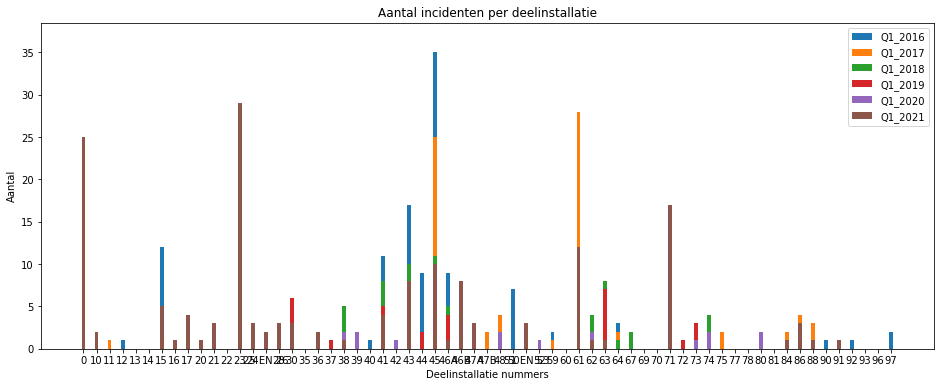

In [143]:
# plot
labels = list(new_dictionary.keys())
width = 0.3

fig, axis = plt.subplots(figsize=(16, 6))

color_label = [f'Q1_{x}' for x in list(melding_per_q_dict.keys())]

# De waarden worden hier wss nog over elkaar heen gepresenteerd. Zoek naar een manier om dit naar elkaar te doen 
# of bouw dit blok om naar de opstapeling. 
for l in range(len(lol)):
    axis.bar(labels, lol[l], width, label=color_label[l])

axis.set_xlabel('Deelinstallatie nummers')
axis.set_ylabel('Aantal')
axis.set_title("Aantal incidenten per deelinstallatie")
axis.legend()

axis.margins(x=0.05, y=0.1)

plt.show()

Onderstaand stuk richt zich op een andere presentatie dan bovenstaande grafiek. In de volgende grafiek is het de bedoeling dat de data van elke di naast elkaar gepresenteerd worden. 

melding_per_q_dict heeft voor het grootste deel de juiste structuur. Moet wel nog omgevormd worden naar een lijst van lijsten, waarbij elke lijst een jaar representeerd. (van dict of dicts naar list of lists)

In [144]:
source = new_dict.copy()
source = {key: source[key] for key in source.keys() if len(source[key]) > 0}
source

{'0': {'2016': 7, '2017': 8, '2018': 12, '2019': 3, '2020': 8, '2021': 25},
 '10': {'2021': 2},
 '11': {'2017': 1},
 '12': {'2016': 1},
 '15': {'2016': 12, '2017': 1, '2019': 2, '2021': 5},
 '16': {'2021': 1},
 '17': {'2020': 2, '2021': 4},
 '20': {'2021': 1},
 '21': {'2016': 2, '2018': 1, '2020': 1, '2021': 3},
 '23': {'2016': 14, '2018': 8, '2019': 2, '2021': 29},
 '24': {'2016': 3, '2017': 1, '2019': 1, '2021': 3},
 '25 EN 26': {'2019': 2, '2021': 2},
 '28': {'2021': 3},
 '30': {'2017': 1, '2019': 6, '2020': 3, '2021': 3},
 '36': {'2016': 2, '2021': 2},
 '37': {'2019': 1},
 '38': {'2017': 1, '2018': 5, '2020': 2, '2021': 1},
 '39': {'2017': 1, '2020': 2},
 '40': {'2016': 1},
 '41': {'2016': 11, '2017': 8, '2018': 8, '2019': 5, '2020': 1, '2021': 4},
 '42': {'2020': 1},
 '43': {'2016': 17, '2017': 7, '2018': 10, '2019': 6, '2020': 3, '2021': 8},
 '44': {'2016': 9, '2017': 1, '2019': 2},
 '45': {'2016': 35, '2017': 25, '2018': 11, '2019': 7, '2020': 7, '2021': 10},
 '46A': {'2016': 9,

In [145]:
"""
new_dictionary structure (result of code below)
{'23': [1, 0, 0],
 '41': [1, 0, 0],
 '43': [0, 1, 0],
 '45': [2, 2, 0],
 '46A': [0, 2, 0],
 '61': [0, 0, 1],
 '62': [1, 0, 0],
 '63': [1, 0, 0],
 '67': [0, 1, 0],
 '74': [0, 1, 0]}
"""
jaren = list(melding_per_q_dict.keys())

new_dictionary = {}

for di_num in new_dict:
    list_of_lists = []
    for i in range(len(jaren)):  
        jaar = jaren[i]
        if jaar in new_dict[di_num].keys():
            list_of_lists.append(new_dict[di_num][jaar])
        else:
            list_of_lists.append(0)
    new_dictionary[di_num] = list_of_lists

"""
lol structure (result of code below)
[[1, 1, 0, 2, 0, 0, 1, 1, 0, 0],
 [0, 0, 1, 2, 2, 0, 0, 0, 1, 1],
 [0, 0, 0, 0, 0, 1, 0, 0, 0, 0]]
"""
lol = []  # list of lists but name was already used
for index in range(len(jaren)):
    l = []
    for di_num in new_dictionary:
        l.append(new_dictionary[di_num][index])
    lol.append(l)

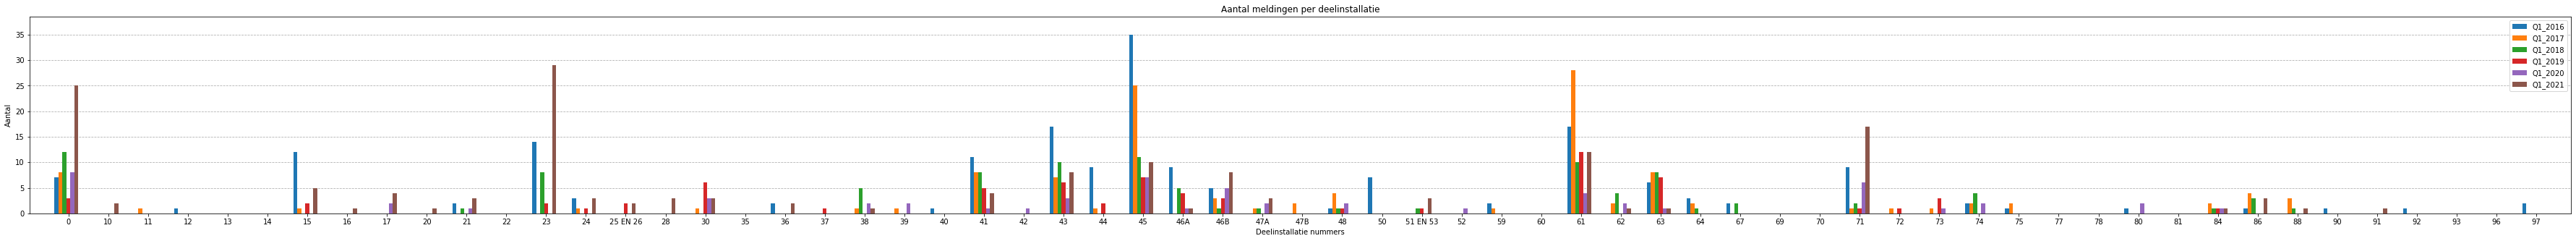

In [146]:
# plot
labels = list(new_dictionary.keys())
x = np.arange(len(labels))  # the x locations of the labels

data = lol.copy()

width = 0.1  # of the bars

fig, axis = plt.subplots(figsize=(len(labels), 5))

color_labels = [f'Q1_{x}' for x in list(melding_per_q_dict.keys())]

# voor het bepalen van de afstand vanaf x zodat de bars niet overlappen
x_generator = (x + (y * (width)) for y in range(-3, 4))  

for _ in range(len(data)):
    bar = axis.bar(x=next(x_generator), height=data[_], width=width, label=color_labels[_])
    
#     for b in bar:
#         height = b.get_height()
#         axis.text(b.get_x() + b.get_width()/2, height, height)
        

# # De waarden worden hier wss nog over elkaar heen gepresenteerd. Zoek naar een manier om dit naar elkaar te doen 
# # of bouw dit blok om naar de opstapeling. 
# for l in range(len(lol)):
#     axis.bar(labels, lol[l], width, label=color_label[l])

axis.set_xlabel('Deelinstallatie nummers')
axis.set_ylabel('Aantal')
axis.set_title("Aantal meldingen per deelinstallatie")

axis.set_xticks(x)
axis.set_xticklabels(labels)

axis.legend()

axis.margins(x=0.01, y=0.1)

axis.set_axisbelow(True)
axis.grid(axis='y', linestyle='--')

plt.show()
add_graph_for_export(fig)

Onderstaande is voor het presenteren van het totale aantal meldingen per kwartaal

In [147]:
notifications_per_quarter = {}
for key in ordered_month_list.keys():
    summed_vals = sa.metadata.sum_values(dictionary=filtered_meldingen_dict[key])
    notifications_per_quarter[key] = summed_vals
    
notifications_per_quarter

{'2016': 184, '2017': 122, '2018': 100, '2019': 71, '2020': 60, '2021': 158}

{'Q1_2016': 184, 'Q1_2017': 122, 'Q1_2018': 100, 'Q1_2019': 71, 'Q1_2020': 60, 'Q1_2021': 158}


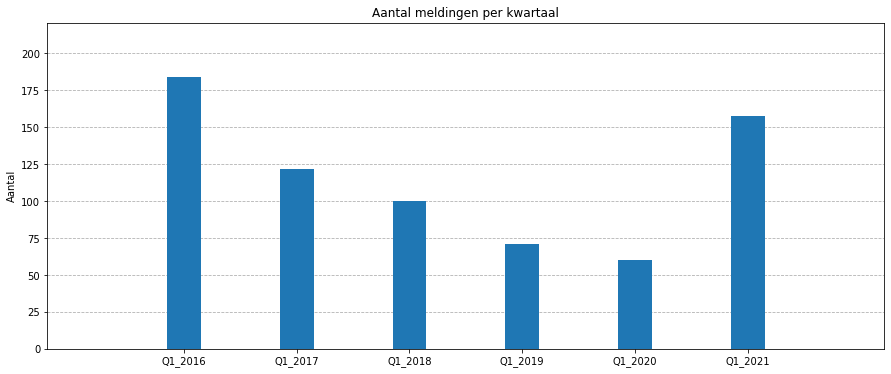

In [148]:
# prep
val_counts_quarter = notifications_per_quarter

ordered_dict = {}
for key in val_counts_quarter.keys():
    new_key = f'Q1_{key}'
    ordered_dict[new_key] = val_counts_quarter[key]

print(ordered_dict) 

# plot
fig, axis = plt.subplots(figsize=(15,6))

axis.bar(ordered_dict.keys(), ordered_dict.values(), width = 0.3)

axis.set_ylabel('Aantal')
axis.set_title("Aantal meldingen per kwartaal")

axis.margins(x=.2, y=.2)

axis.set_axisbelow(True)
axis.grid(axis='y', linestyle='--')

plt.show()
add_graph_for_export(fig)

## Vergelijking storingen Qx met alle voorgaande Qx

In [149]:
months_to_exclude = [sa.metadata._quarters[q][i] for q in sa.metadata._quarters.keys() if q != 'Q1' for i in range(len(sa.metadata._quarters[q]))]
print(f'Months to exclude in function get_month_list: {months_to_exclude}\n')

month_list = sa.metadata.get_month_list(exclude_month=months_to_exclude)
print(f'month list = {month_list}')

ordered_month_list = sa.metadata.order_month_list_by_year(month_list=month_list)
ordered_month_list

Months to exclude in function get_month_list: ['04', '05', '06', '07', '08', '09', '10', '11', '12']

month list = ['01_2016', '02_2016', '03_2016', '01_2017', '02_2017', '03_2017', '01_2018', '02_2018', '03_2018', '01_2019', '02_2019', '03_2019', '01_2020', '02_2020', '03_2020', '01_2021', '02_2021', '03_2021']


{'2016': ['01_2016', '02_2016', '03_2016'],
 '2017': ['01_2017', '02_2017', '03_2017'],
 '2018': ['01_2018', '02_2018', '03_2018'],
 '2019': ['01_2019', '02_2019', '03_2019'],
 '2020': ['01_2020', '02_2020', '03_2020'],
 '2021': ['01_2021', '02_2021', '03_2021']}

In [150]:
filtered_storingen_dict = {}
for key in ordered_month_list.keys():
    filtered_storingen = sa.metadata.filter_dictionary_keys(dictionary=updated_histo_storingen, keys=ordered_month_list[key])
    filtered_storingen_dict[key] = filtered_storingen
    
filtered_storingen_dict

{'2016': {'01_2016': {'61': 3,
   '43': 2,
   '45': 3,
   '41': 3,
   '23': 1,
   '46B': 1,
   '44': 1,
   '74': 2,
   '21': 1,
   '15': 2,
   '36': 2,
   '67': 1,
   '92': 1},
  '02_2016': {'61': 2,
   '45': 2,
   '41': 4,
   '63': 2,
   '23': 13,
   '44': 7,
   '71': 5,
   '15': 1,
   '75': 1},
  '03_2016': {'61': 4,
   '43': 7,
   '45': 3,
   '41': 1,
   '63': 1,
   '24': 2,
   '46A': 1,
   '71': 1,
   '86': 1,
   '67': 1,
   '64': 1,
   '80': 1}},
 '2017': {'01_2017': {'61': 11,
   '43': 2,
   '45': 10,
   '24': 1,
   '71': 1,
   '74': 1,
   '62': 1,
   '73': 1,
   '72': 1,
   '75': 1,
   '47B': 1},
  '02_2017': {'61': 5,
   '45': 3,
   '41': 3,
   '63': 1,
   '46B': 3,
   '44': 1,
   '74': 1,
   '88': 2,
   '15': 1,
   '30': 1,
   '48': 1},
  '03_2017': {'61': 1,
   '43': 5,
   '45': 2,
   '41': 2,
   '86': 2,
   '88': 1,
   '62': 1,
   '84': 1,
   '64': 2}},
 '2018': {'01_2018': {'61': 3,
   '43': 2,
   '45': 1,
   '41': 1,
   '63': 4,
   '23': 1,
   '71': 1,
   '86': 1,
   '47A'

In [151]:
storing_per_q_dict = {}
for year in filtered_storingen_dict:  # keys als '2016', '2021'
    if year not in storing_per_q_dict.keys():  # add key to new dict
        storing_per_q_dict[year] = {}
    
    for d in filtered_storingen_dict[year]:  # keys als '01_2016', '02_2016'
        for di in filtered_storingen_dict[year][d]:  # keys als di_nummers '45', '61'
            if di not in storing_per_q_dict[year].keys():
                storing_per_q_dict[year][di] = filtered_storingen_dict[year][d][di]
            else:
                storing_per_q_dict[year][di] += filtered_storingen_dict[year][d][di]
                
storing_per_q_dict  # wordt gebruikt om bars van bar plot naast elkaar te plotten

{'2016': {'61': 9,
  '43': 9,
  '45': 8,
  '41': 8,
  '23': 14,
  '46B': 1,
  '44': 8,
  '74': 2,
  '21': 1,
  '15': 3,
  '36': 2,
  '67': 2,
  '92': 1,
  '63': 3,
  '71': 6,
  '75': 1,
  '24': 2,
  '46A': 1,
  '86': 1,
  '64': 1,
  '80': 1},
 '2017': {'61': 17,
  '43': 7,
  '45': 15,
  '24': 1,
  '71': 1,
  '74': 2,
  '62': 2,
  '73': 1,
  '72': 1,
  '75': 1,
  '47B': 1,
  '41': 5,
  '63': 1,
  '46B': 3,
  '44': 1,
  '88': 3,
  '15': 1,
  '30': 1,
  '48': 1,
  '86': 2,
  '84': 1,
  '64': 2},
 '2018': {'61': 4,
  '43': 10,
  '45': 3,
  '41': 4,
  '63': 6,
  '23': 8,
  '71': 2,
  '86': 1,
  '47A': 1,
  '88': 1,
  '21': 1,
  '62': 3,
  '38': 3,
  '46B': 1,
  '46A': 3,
  '74': 4,
  '67': 2,
  '84': 1,
  '51 EN 53': 1,
  '48': 1},
 '2019': {'61': 10,
  '43': 3,
  '45': 4,
  '41': 4,
  '63': 4,
  '46B': 2,
  '24': 1,
  '46A': 1,
  '15': 2,
  '84': 1,
  '73': 3,
  '71': 1,
  '51 EN 53': 1,
  '48': 1,
  '25 EN 26': 1,
  '30': 3,
  '37': 1},
 '2020': {'43': 3,
  '45': 1,
  '63': 1,
  '71': 6,


In [152]:
# switching level 1 and level 2 keys
present_di_numbers = sa.metadata.contract_info()['aanwezige_deelinstallaties']

new_dict = {x: {} for x in sorted(present_di_numbers)}

for lvl1_key in melding_per_q_dict.keys():
    
    for lvl2_key in melding_per_q_dict[lvl1_key].keys():

        val = melding_per_q_dict[lvl1_key][lvl2_key]
        new_dict[lvl2_key][lvl1_key] = val

new_dict

{'0': {'2016': 7, '2017': 8, '2018': 12, '2019': 3, '2020': 8, '2021': 25},
 '10': {'2021': 2},
 '11': {'2017': 1},
 '12': {'2016': 1},
 '13': {},
 '14': {},
 '15': {'2016': 12, '2017': 1, '2019': 2, '2021': 5},
 '16': {'2021': 1},
 '17': {'2020': 2, '2021': 4},
 '20': {'2021': 1},
 '21': {'2016': 2, '2018': 1, '2020': 1, '2021': 3},
 '22': {},
 '23': {'2016': 14, '2018': 8, '2019': 2, '2021': 29},
 '24': {'2016': 3, '2017': 1, '2019': 1, '2021': 3},
 '25 EN 26': {'2019': 2, '2021': 2},
 '28': {'2021': 3},
 '30': {'2017': 1, '2019': 6, '2020': 3, '2021': 3},
 '35': {},
 '36': {'2016': 2, '2021': 2},
 '37': {'2019': 1},
 '38': {'2017': 1, '2018': 5, '2020': 2, '2021': 1},
 '39': {'2017': 1, '2020': 2},
 '40': {'2016': 1},
 '41': {'2016': 11, '2017': 8, '2018': 8, '2019': 5, '2020': 1, '2021': 4},
 '42': {'2020': 1},
 '43': {'2016': 17, '2017': 7, '2018': 10, '2019': 6, '2020': 3, '2021': 8},
 '44': {'2016': 9, '2017': 1, '2019': 2},
 '45': {'2016': 35, '2017': 25, '2018': 11, '2019': 7,

In [153]:
source = new_dict.copy()
source = {key: source[key] for key in source.keys() if len(source[key]) > 0}
source

{'0': {'2016': 7, '2017': 8, '2018': 12, '2019': 3, '2020': 8, '2021': 25},
 '10': {'2021': 2},
 '11': {'2017': 1},
 '12': {'2016': 1},
 '15': {'2016': 12, '2017': 1, '2019': 2, '2021': 5},
 '16': {'2021': 1},
 '17': {'2020': 2, '2021': 4},
 '20': {'2021': 1},
 '21': {'2016': 2, '2018': 1, '2020': 1, '2021': 3},
 '23': {'2016': 14, '2018': 8, '2019': 2, '2021': 29},
 '24': {'2016': 3, '2017': 1, '2019': 1, '2021': 3},
 '25 EN 26': {'2019': 2, '2021': 2},
 '28': {'2021': 3},
 '30': {'2017': 1, '2019': 6, '2020': 3, '2021': 3},
 '36': {'2016': 2, '2021': 2},
 '37': {'2019': 1},
 '38': {'2017': 1, '2018': 5, '2020': 2, '2021': 1},
 '39': {'2017': 1, '2020': 2},
 '40': {'2016': 1},
 '41': {'2016': 11, '2017': 8, '2018': 8, '2019': 5, '2020': 1, '2021': 4},
 '42': {'2020': 1},
 '43': {'2016': 17, '2017': 7, '2018': 10, '2019': 6, '2020': 3, '2021': 8},
 '44': {'2016': 9, '2017': 1, '2019': 2},
 '45': {'2016': 35, '2017': 25, '2018': 11, '2019': 7, '2020': 7, '2021': 10},
 '46A': {'2016': 9,

In [154]:
"""
new_dictionary structure (result of code below)
{'23': [1, 0, 0],
 '41': [1, 0, 0],
 '43': [0, 1, 0],
 '45': [2, 2, 0],
 '46A': [0, 2, 0],
 '61': [0, 0, 1],
 '62': [1, 0, 0],
 '63': [1, 0, 0],
 '67': [0, 1, 0],
 '74': [0, 1, 0]}
"""
jaren = list(storing_per_q_dict.keys())

new_dictionary = {}

for di_num in new_dict:
    list_of_lists = []
    for i in range(len(jaren)):  
        jaar = jaren[i]
        if jaar in new_dict[di_num].keys():
            list_of_lists.append(new_dict[di_num][jaar])
        else:
            list_of_lists.append(0)
    new_dictionary[di_num] = list_of_lists

"""
lol structure (result of code below)
[[1, 1, 0, 2, 0, 0, 1, 1, 0, 0],
 [0, 0, 1, 2, 2, 0, 0, 0, 1, 1],
 [0, 0, 0, 0, 0, 1, 0, 0, 0, 0]]
"""
lol = []  # list of lists but name was already used
for index in range(len(jaren)):
    l = []
    for di_num in new_dictionary:
        l.append(new_dictionary[di_num][index])
    lol.append(l)

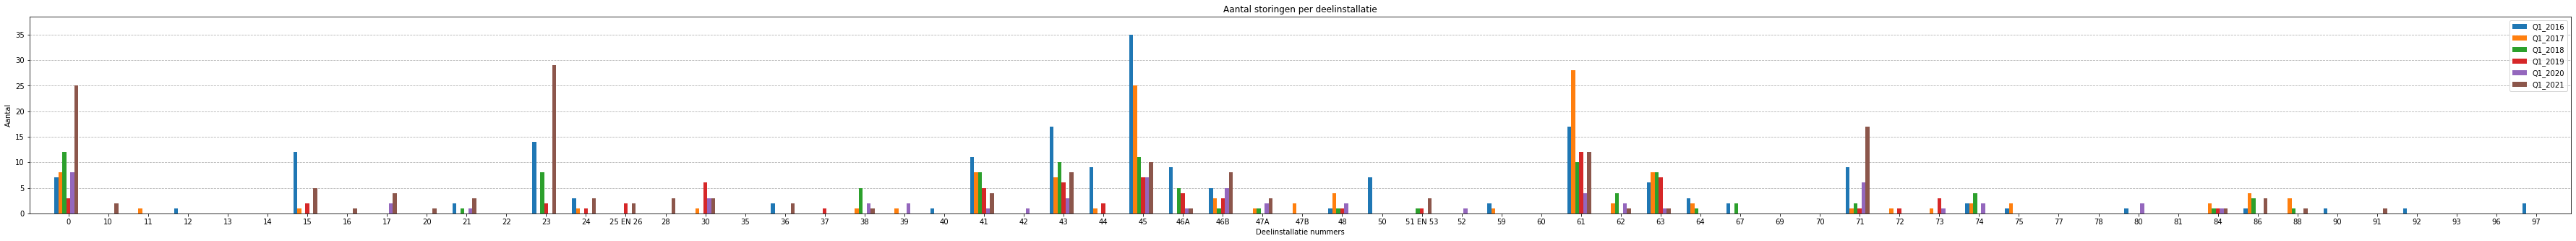

In [155]:
# plot
labels = list(new_dictionary.keys())
x = np.arange(len(labels))  # the x locations of the labels

data = lol.copy()

width = 0.1  # of the bars

fig, axis = plt.subplots(figsize=(len(labels), 5))

color_labels = [f'Q1_{x}' for x in list(melding_per_q_dict.keys())]

# voor het bepalen van de afstand vanaf x zodat de bars niet overlappen
x_generator = (x + (y * (width)) for y in range(-3, 4))  

for _ in range(len(data)):
    bar = axis.bar(x=next(x_generator), height=data[_], width=width, label=color_labels[_])
    
#     for b in bar:
#         height = b.get_height()
#         axis.text(b.get_x() + b.get_width()/2, height, height)
        

# # De waarden worden hier wss nog over elkaar heen gepresenteerd. Zoek naar een manier om dit naar elkaar te doen 
# # of bouw dit blok om naar de opstapeling. 
# for l in range(len(lol)):
#     axis.bar(labels, lol[l], width, label=color_label[l])

axis.set_xlabel('Deelinstallatie nummers')
axis.set_ylabel('Aantal')
axis.set_title("Aantal storingen per deelinstallatie")

axis.set_xticks(x)
axis.set_xticklabels(labels)

axis.legend()

axis.margins(x=0.01, y=0.1)

axis.set_axisbelow(True)
axis.grid(axis='y', linestyle='--')

plt.show()
add_graph_for_export(fig)

In [156]:
storingen_per_quarter = {}
for key in ordered_month_list.keys():
    summed_vals = sa.metadata.sum_values(dictionary=filtered_storingen_dict[key])
    storingen_per_quarter[key] = summed_vals

storingen_per_quarter

{'2016': 84, '2017': 70, '2018': 60, '2019': 43, '2020': 31, '2021': 98}

{'Q1_2016': 84, 'Q1_2017': 70, 'Q1_2018': 60, 'Q1_2019': 43, 'Q1_2020': 31, 'Q1_2021': 98}


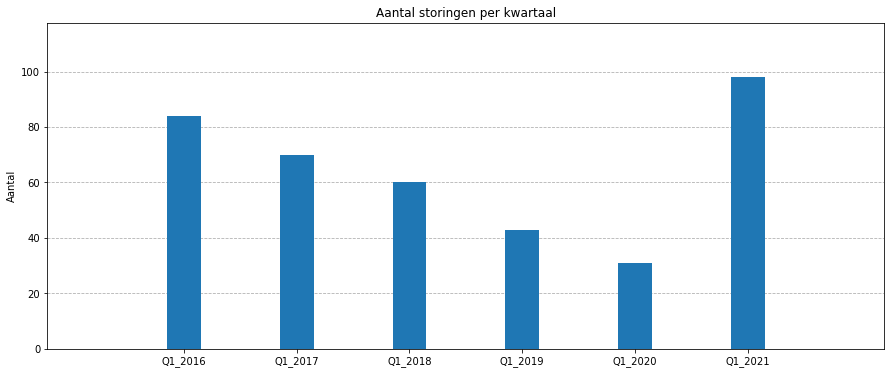

In [157]:
# prep
val_counts_quarter = storingen_per_quarter

# Changing key names 'year' => 'Qx_year'
ordered_dict = {}
for key in val_counts_quarter.keys():
    new_key = f'Q1_{key}'  
    ordered_dict[new_key] = val_counts_quarter[key]

print(ordered_dict) 

# plot
fig, axis = plt.subplots(figsize=(15,6))

axis.bar(ordered_dict.keys(), ordered_dict.values(), width = 0.3)

axis.set_ylabel('Aantal')
axis.set_title("Aantal storingen per kwartaal")

axis.margins(x=.2, y=.2)

axis.set_axisbelow(True)
axis.grid(axis='y', linestyle='--')

plt.show()
add_graph_for_export(fig)

## Vergelijking voorgaande kwartaal met huidinge kwartaal

### Meldingen

In [158]:
source = {'Q4_2020': [f'{x}_2020' for x in sa.metadata._quarters['Q4'].copy()],
          'Q1_2021': [f'{x}_2021' for x in sa.metadata._quarters['Q1'].copy()]}
source

{'Q4_2020': ['10_2020', '11_2020', '12_2020'],
 'Q1_2021': ['01_2021', '02_2021', '03_2021']}

In [159]:
# fetching notifications per di number for each month from each quarter in source
source_stage_2 = {}
for key in source.keys():
    filtered_data = sa.metadata.filter_dictionary_keys(dictionary=updated_histo, keys=source[key])
    source_stage_2[key] = filtered_data
    
source_stage_2

{'Q4_2020': {'10_2020': {'45': 2,
   '61': 1,
   '23': 1,
   '63': 4,
   '43': 2,
   '41': 2,
   '46B': 2,
   '46A': 1,
   '24': 1,
   '71': 3,
   '48': 1,
   '86': 4,
   '62': 1,
   '74': 2,
   '51 EN 53': 2,
   '25 EN 26': 2,
   '42': 3,
   '47B': 2},
  '11_2020': {'45': 3,
   '61': 3,
   '23': 2,
   '63': 1,
   '43': 1,
   '41': 2,
   '46B': 3,
   '71': 1,
   '48': 1,
   '47A': 1,
   '47B': 2,
   '60': 1},
  '12_2020': {'45': 5,
   '23': 3,
   '43': 1,
   '41': 1,
   '0': 1,
   '46B': 2,
   '48': 1,
   '15': 1,
   '73': 1,
   '91': 4,
   '17': 2}},
 'Q1_2021': {'01_2021': {'45': 3,
   '61': 3,
   '23': 2,
   '43': 5,
   '41': 1,
   '0': 10,
   '46B': 3,
   '24': 3,
   '71': 5,
   '15': 2,
   '88': 1,
   '51 EN 53': 1,
   '25 EN 26': 2,
   '10': 1,
   '28': 3},
  '02_2021': {'45': 3,
   '61': 7,
   '23': 2,
   '43': 1,
   '41': 3,
   '0': 13,
   '46B': 5,
   '46A': 1,
   '71': 9,
   '47A': 3,
   '86': 1,
   '15': 2,
   '30': 1,
   '84': 1,
   '51 EN 53': 1,
   '36': 1,
   '10': 1,
  

In [160]:
# eliminating the month key, by making a frequency table for eacht quarter
source_stage_3 = {quarter_key: {} for quarter_key in source_stage_2.keys()}

for quarter_key in source_stage_2.keys():
    
    for month_key in source_stage_2[quarter_key].keys():
        
        for di_key, value in source_stage_2[quarter_key][month_key].items():
            
            if di_key not in source_stage_3[quarter_key]:
                source_stage_3[quarter_key][di_key] = value
            else:
                source_stage_3[quarter_key][di_key] += value

source_stage_3               

{'Q4_2020': {'45': 10,
  '61': 4,
  '23': 6,
  '63': 5,
  '43': 4,
  '41': 5,
  '46B': 7,
  '46A': 1,
  '24': 1,
  '71': 4,
  '48': 3,
  '86': 4,
  '62': 1,
  '74': 2,
  '51 EN 53': 2,
  '25 EN 26': 2,
  '42': 3,
  '47B': 4,
  '47A': 1,
  '60': 1,
  '0': 1,
  '15': 1,
  '73': 1,
  '91': 4,
  '17': 2},
 'Q1_2021': {'45': 10,
  '61': 12,
  '23': 29,
  '43': 8,
  '41': 4,
  '0': 25,
  '46B': 8,
  '24': 3,
  '71': 17,
  '15': 5,
  '88': 1,
  '51 EN 53': 3,
  '25 EN 26': 2,
  '10': 2,
  '28': 3,
  '46A': 1,
  '47A': 3,
  '86': 3,
  '30': 3,
  '84': 1,
  '36': 2,
  '17': 4,
  '16': 1,
  '63': 1,
  '21': 3,
  '62': 1,
  '38': 1,
  '91': 1,
  '20': 1}}

In [161]:
# switching level 1 and level 2 keys from source_stage_3
present_di_numbers = sa.metadata.contract_info()['aanwezige_deelinstallaties']

source_stage_4 = {x: {} for x in sorted(present_di_numbers)}

for lvl1_key in source_stage_3.keys():
    
    for lvl2_key, value in source_stage_3[lvl1_key].items():
        source_stage_4[lvl2_key][lvl1_key] = value

source_stage_4

{'0': {'Q4_2020': 1, 'Q1_2021': 25},
 '10': {'Q1_2021': 2},
 '11': {},
 '12': {},
 '13': {},
 '14': {},
 '15': {'Q4_2020': 1, 'Q1_2021': 5},
 '16': {'Q1_2021': 1},
 '17': {'Q4_2020': 2, 'Q1_2021': 4},
 '20': {'Q1_2021': 1},
 '21': {'Q1_2021': 3},
 '22': {},
 '23': {'Q4_2020': 6, 'Q1_2021': 29},
 '24': {'Q4_2020': 1, 'Q1_2021': 3},
 '25 EN 26': {'Q4_2020': 2, 'Q1_2021': 2},
 '28': {'Q1_2021': 3},
 '30': {'Q1_2021': 3},
 '35': {},
 '36': {'Q1_2021': 2},
 '37': {},
 '38': {'Q1_2021': 1},
 '39': {},
 '40': {},
 '41': {'Q4_2020': 5, 'Q1_2021': 4},
 '42': {'Q4_2020': 3},
 '43': {'Q4_2020': 4, 'Q1_2021': 8},
 '44': {},
 '45': {'Q4_2020': 10, 'Q1_2021': 10},
 '46A': {'Q4_2020': 1, 'Q1_2021': 1},
 '46B': {'Q4_2020': 7, 'Q1_2021': 8},
 '47A': {'Q4_2020': 1, 'Q1_2021': 3},
 '47B': {'Q4_2020': 4},
 '48': {'Q4_2020': 3},
 '50': {},
 '51 EN 53': {'Q4_2020': 2, 'Q1_2021': 3},
 '52': {},
 '59': {},
 '60': {'Q4_2020': 1},
 '61': {'Q4_2020': 4, 'Q1_2021': 12},
 '62': {'Q4_2020': 1, 'Q1_2021': 1},
 '63':

In [162]:
# transforming source_stage_4 data to be a list_of_lists where each list represents a quarter

"""
_data structure (result of code below)
{'23': [1, 0, 0],
 '41': [1, 0, 0],
 '43': [0, 1, 0],
 '45': [2, 2, 0],
 '46A': [0, 2, 0],
 '61': [0, 0, 1],
 '62': [1, 0, 0],
 '63': [1, 0, 0],
 '67': [0, 1, 0],
 '74': [0, 1, 0]}
"""
lists_in_lol = list(source_stage_3.keys())
num_lists = len(lists_in_lol)


_data = {}

for di_num in source_stage_4:
    _list = []
    for i in range(num_lists):  
        l = lists_in_lol[i]  # variable representing the time period in source_stage_4 or the keys of source_stage_3
        if l in source_stage_4[di_num].keys():
            _list.append(source_stage_4[di_num][l])
        else:
            _list.append(0)
    _data[di_num] = _list  

_data

{'0': [1, 25],
 '10': [0, 2],
 '11': [0, 0],
 '12': [0, 0],
 '13': [0, 0],
 '14': [0, 0],
 '15': [1, 5],
 '16': [0, 1],
 '17': [2, 4],
 '20': [0, 1],
 '21': [0, 3],
 '22': [0, 0],
 '23': [6, 29],
 '24': [1, 3],
 '25 EN 26': [2, 2],
 '28': [0, 3],
 '30': [0, 3],
 '35': [0, 0],
 '36': [0, 2],
 '37': [0, 0],
 '38': [0, 1],
 '39': [0, 0],
 '40': [0, 0],
 '41': [5, 4],
 '42': [3, 0],
 '43': [4, 8],
 '44': [0, 0],
 '45': [10, 10],
 '46A': [1, 1],
 '46B': [7, 8],
 '47A': [1, 3],
 '47B': [4, 0],
 '48': [3, 0],
 '50': [0, 0],
 '51 EN 53': [2, 3],
 '52': [0, 0],
 '59': [0, 0],
 '60': [1, 0],
 '61': [4, 12],
 '62': [1, 1],
 '63': [5, 1],
 '64': [0, 0],
 '67': [0, 0],
 '69': [0, 0],
 '70': [0, 0],
 '71': [4, 17],
 '72': [0, 0],
 '73': [1, 0],
 '74': [2, 0],
 '75': [0, 0],
 '77': [0, 0],
 '78': [0, 0],
 '80': [0, 0],
 '81': [0, 0],
 '84': [0, 1],
 '86': [4, 3],
 '88': [0, 1],
 '90': [0, 0],
 '91': [4, 1],
 '92': [0, 0],
 '93': [0, 0],
 '96': [0, 0],
 '97': [0, 0]}

In [163]:
"""
data structure (result of code below)
[[1, 1, 0, 2, 0, 0, 1, 1, 0, 0],
 [0, 0, 1, 2, 2, 0, 0, 0, 1, 1],
 [0, 0, 0, 0, 0, 1, 0, 0, 0, 0]]
"""
data = []  # list of lists 
for index in range(num_lists):
    _list = []
    for di_num in _data:
        _list.append(_data[di_num][index])
    data.append(_list)
    
data

[[1,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  2,
  0,
  0,
  0,
  6,
  1,
  2,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  5,
  3,
  4,
  0,
  10,
  1,
  7,
  1,
  4,
  3,
  0,
  2,
  0,
  0,
  1,
  4,
  1,
  5,
  0,
  0,
  0,
  0,
  4,
  0,
  1,
  2,
  0,
  0,
  0,
  0,
  0,
  0,
  4,
  0,
  0,
  4,
  0,
  0,
  0,
  0],
 [25,
  2,
  0,
  0,
  0,
  0,
  5,
  1,
  4,
  1,
  3,
  0,
  29,
  3,
  2,
  3,
  3,
  0,
  2,
  0,
  1,
  0,
  0,
  4,
  0,
  8,
  0,
  10,
  1,
  8,
  3,
  0,
  0,
  0,
  3,
  0,
  0,
  0,
  12,
  1,
  1,
  0,
  0,
  0,
  0,
  17,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  3,
  1,
  0,
  1,
  0,
  0,
  0,
  0]]

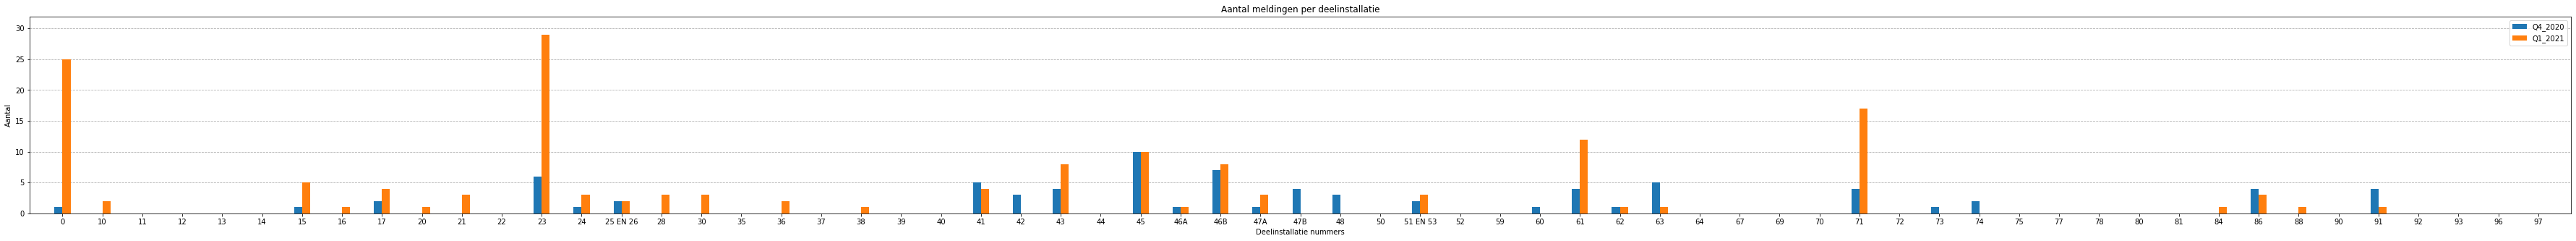

In [164]:
# plot
labels = list(_data.keys())
x = np.arange(len(labels))  # the x locations of the labels

bar_width = 0.2

fig, axis = plt.subplots(figsize=(len(labels), 5))

color_labels = list(source_stage_3.keys())  # names for in legend

# voor het bepalen van de afstand vanaf x zodat de bars niet overlappen
x_generator = (x + (y * (bar_width)) for y in (0, 1))  

# Toevoegen van de bars
for _ in range(len(data)):
    bar = axis.bar(x=next(x_generator), height=data[_], width=bar_width, label=color_labels[_])

# titel en namen van de assen
axis.set_xlabel('Deelinstallatie nummers')
axis.set_ylabel('Aantal')
axis.set_title("Aantal meldingen per deelinstallatie")

# namen langs de assen
axis.set_xticks(x + bar_width / len(data))
axis.set_xticklabels(labels)

axis.margins(x=0.01, y=0.1)

axis.set_axisbelow(True)
axis.grid(axis='y', linestyle='--')

axis.legend()

# fig.autofmt_xdate(rotation=45)

plt.show()
add_graph_for_export(fig)

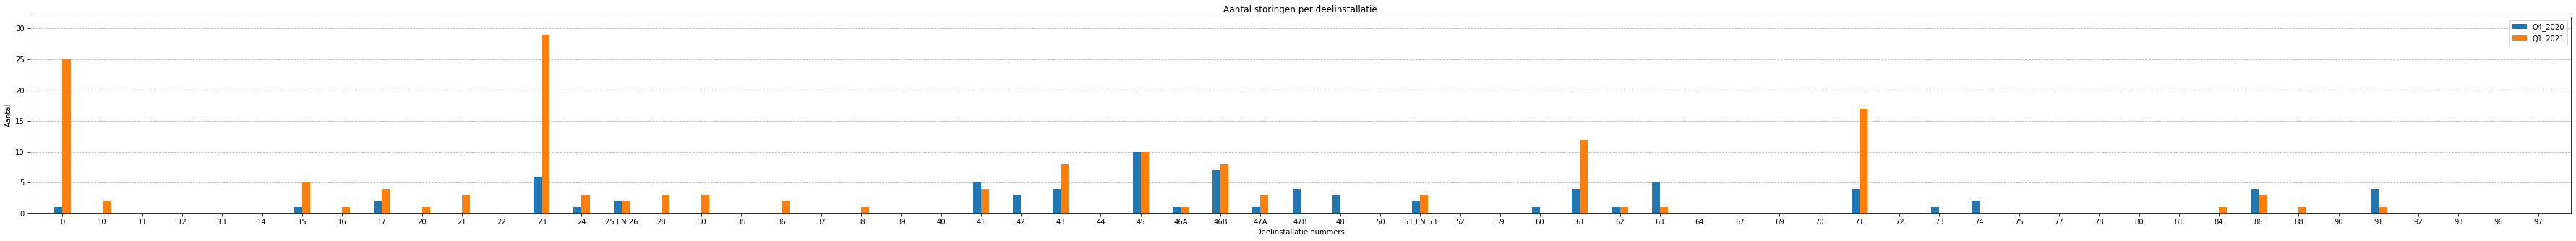

In [191]:
prepped_data = pp.prep(updated_histo, 
                       time_range=['10-2020', '03-2021'], 
                       available_categories=sa.metadata.contract_info()['aanwezige_deelinstallaties'], 
                       time_key='rapport datum', 
                       category_key='sbs', 
                       bin_size='quarter')

pp.plot(input_data=prepped_data, 
        plot_type='side-by-side', 
        category_labels=sa.metadata.contract_info()['aanwezige_deelinstallaties'], 
        bin_labels=pp.last_seen_bin_names)

{'Q4_2020': 79, 'Q1_2021': 158}


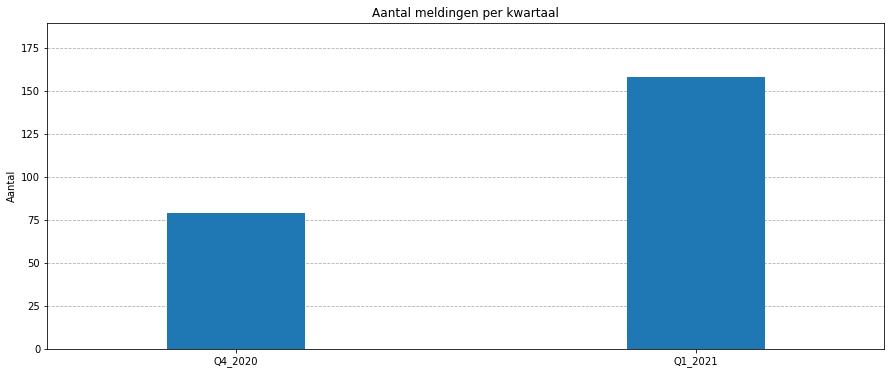

In [165]:
# prep
data = {}

for key in source_stage_2.keys():
    summed_vals = sa.metadata.sum_values(dictionary=source_stage_2[key])
    data[key] = summed_vals

print(data)
    
# plot
fig, axis = plt.subplots(figsize=(15,6))

axis.bar(data.keys(), data.values(), width = 0.3)

axis.set_ylabel('Aantal')
axis.set_title("Aantal meldingen per kwartaal")

axis.margins(x=.2, y=.2)

axis.set_axisbelow(True)
axis.grid(axis='y', linestyle='--')

plt.show()
add_graph_for_export(fig)

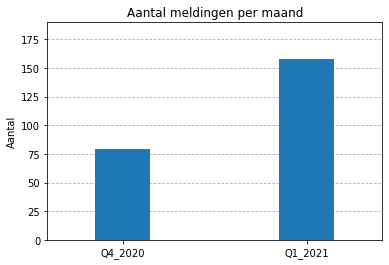

In [192]:
summary_data = pp.prep_summary(updated_histo, 
                               time_range=['10-2020', '03-2021'], 
                               available_categories=sa.metadata.contract_info()['aanwezige_deelinstallaties'],
                               bin_size='quarter')

pp.plot_summary(input_data=summary_data)

In [166]:
# Proof of work for the preperation actions in PrepNPlot
from prepnplot import PrepNPlot
pp = PrepNPlot()

x = [datetime.strptime(t, '%d-%m-%y %H:%M:%S') for t in sf_data.loc[:, 'rapport datum']]
tr = [min(x), max(x)]

test_step_one = pp._prep_first_step(input_object=updated_histo_storingen,
                                    time_range=['10-2020', '3-2021'],
                                    available_categories=sa.metadata.contract_info()['aanwezige_deelinstallaties'],
                                    bin_size='quarter'
                                    )

# input_object = (sf_data, 'rapport datum', 'type melding (Storing/Incident/Preventief/Onterecht)')
# test_step_one = pp._prep_first_step(input_object=input_object,
#                                     time_range=tr, bin_size='quarter')

print(f"result 1 = {test_step_one}")

test_step_two = pp._prep_second_step(input_dict=test_step_one)
# test_step_two = test_step_one

print(f"result 2 = {test_step_two}")

test_step_three = pp._prep_end_step(input_dict=test_step_two, bin_names=[_ for _ in test_step_two.keys()])

print(f"result 3 = {test_step_three}")

# test_prep = pp.prep(input_object=sf_data,
#                     categorical_key='type melding (Storing/Incident/Preventief/Onterecht)',
#                     time_key='rapport datum',
#                     time_range=tr,
#                     bin_size='quarter')

# print(f"result last = {test_prep}")
"""
test to handle list instead of dict 
This happens in the case were no bin_size is specified. one of the first tasks returns a list of the month numbers. The
problem is the difference between the behavior of a dict and a list.
"""
test_prep = pp.prep(input_object=updated_histo_storingen,
                    time_range=['10-2020', '3-2021'],
                    available_categories=sa.metadata.contract_info()['aanwezige_deelinstallaties'],
                    bin_size='quarter'
                    )

print(f"result last = {test_prep}")
print(f"length of lists in result are equal: {len(test_prep[0]) == len(test_prep[-1])}")

result 1 = {'Q4_2020': {'10_2020': {'0': 0, '10': 0, '11': 0, '12': 0, '13': 0, '14': 0, '15': 0, '16': 0, '17': 0, '20': 0, '21': 0, '22': 0, '23': 1, '24': 0, '25 EN 26': 2, '28': 0, '30': 0, '35': 0, '36': 0, '37': 0, '38': 0, '39': 0, '40': 0, '41': 1, '42': 1, '43': 0, '44': 0, '45': 0, '46A': 1, '46B': 0, '47A': 0, '47B': 1, '48': 0, '50': 0, '51 EN 53': 2, '52': 0, '59': 0, '60': 0, '61': 1, '62': 0, '63': 1, '64': 0, '67': 0, '69': 0, '70': 0, '71': 3, '72': 0, '73': 0, '74': 1, '75': 0, '77': 0, '78': 0, '80': 0, '81': 0, '84': 0, '86': 0, '88': 0, '90': 0, '91': 0, '92': 0, '93': 0, '96': 0, '97': 0}, '11_2020': {'0': 0, '10': 0, '11': 0, '12': 0, '13': 0, '14': 0, '15': 0, '16': 0, '17': 0, '20': 0, '21': 0, '22': 0, '23': 2, '24': 0, '25 EN 26': 0, '28': 0, '30': 0, '35': 0, '36': 0, '37': 0, '38': 0, '39': 0, '40': 0, '41': 0, '42': 0, '43': 1, '44': 0, '45': 0, '46A': 0, '46B': 1, '47A': 1, '47B': 0, '48': 0, '50': 0, '51 EN 53': 0, '52': 0, '59': 0, '60': 1, '61': 1, '62

### Storingen

In [167]:
source = {'Q4_2020': [f'{x}_2020' for x in sa.metadata._quarters['Q4'].copy()],
          'Q1_2021': [f'{x}_2021' for x in sa.metadata._quarters['Q1'].copy()]}
source

{'Q4_2020': ['10_2020', '11_2020', '12_2020'],
 'Q1_2021': ['01_2021', '02_2021', '03_2021']}

In [168]:
# fetching notifications per di number for each month from each quarter in source
source_stage_2 = {}
for key in source.keys():
    filtered_data = sa.metadata.filter_dictionary_keys(dictionary=updated_histo_storingen, keys=source[key])
    source_stage_2[key] = filtered_data
    
source_stage_2

{'Q4_2020': {'10_2020': {'61': 1,
   '41': 1,
   '63': 1,
   '23': 1,
   '46A': 1,
   '71': 3,
   '74': 1,
   '51 EN 53': 2,
   '25 EN 26': 2,
   '42': 1,
   '47B': 1},
  '11_2020': {'61': 1,
   '43': 1,
   '63': 1,
   '23': 2,
   '46B': 1,
   '71': 1,
   '47A': 1,
   '60': 1},
  '12_2020': {'43': 1,
   '45': 2,
   '41': 1,
   '23': 2,
   '46B': 2,
   '73': 1,
   '91': 4,
   '17': 2}},
 'Q1_2021': {'01_2021': {'61': 2,
   '43': 3,
   '45': 3,
   '23': 2,
   '46B': 3,
   '71': 4,
   '88': 1,
   '15': 2,
   '25 EN 26': 2,
   '0': 2,
   '28': 1},
  '02_2021': {'61': 5,
   '43': 1,
   '45': 2,
   '41': 3,
   '23': 2,
   '71': 7,
   '86': 1,
   '47A': 3,
   '15': 1,
   '30': 1,
   '84': 1,
   '51 EN 53': 1,
   '0': 2,
   '17': 2},
  '03_2021': {'43': 2,
   '23': 25,
   '71': 3,
   '86': 2,
   '21': 1,
   '15': 1,
   '62': 1,
   '30': 2,
   '36': 1,
   '38': 1,
   '17': 2}}}

In [169]:
# eliminating the month key, by making a frequency table for eacht quarter
source_stage_3 = {quarter_key: {} for quarter_key in source_stage_2.keys()}

for quarter_key in source_stage_2.keys():
    
    for month_key in source_stage_2[quarter_key].keys():
        
        for di_key, value in source_stage_2[quarter_key][month_key].items():
            
            if di_key not in source_stage_3[quarter_key]:
                source_stage_3[quarter_key][di_key] = value
            else:
                source_stage_3[quarter_key][di_key] += value

source_stage_3

{'Q4_2020': {'61': 2,
  '41': 2,
  '63': 2,
  '23': 5,
  '46A': 1,
  '71': 4,
  '74': 1,
  '51 EN 53': 2,
  '25 EN 26': 2,
  '42': 1,
  '47B': 1,
  '43': 2,
  '46B': 3,
  '47A': 1,
  '60': 1,
  '45': 2,
  '73': 1,
  '91': 4,
  '17': 2},
 'Q1_2021': {'61': 7,
  '43': 6,
  '45': 5,
  '23': 29,
  '46B': 3,
  '71': 14,
  '88': 1,
  '15': 4,
  '25 EN 26': 2,
  '0': 4,
  '28': 1,
  '41': 3,
  '86': 3,
  '47A': 3,
  '30': 3,
  '84': 1,
  '51 EN 53': 1,
  '17': 4,
  '21': 1,
  '62': 1,
  '36': 1,
  '38': 1}}

In [170]:
# switching level 1 and level 2 keys from source_stage_3
present_di_numbers = sa.metadata.contract_info()['aanwezige_deelinstallaties']

source_stage_4 = {x: {} for x in sorted(present_di_numbers)}

for lvl1_key in source_stage_3.keys():
    
    for lvl2_key, value in source_stage_3[lvl1_key].items():
        source_stage_4[lvl2_key][lvl1_key] = value

source_stage_4

{'0': {'Q1_2021': 4},
 '10': {},
 '11': {},
 '12': {},
 '13': {},
 '14': {},
 '15': {'Q1_2021': 4},
 '16': {},
 '17': {'Q4_2020': 2, 'Q1_2021': 4},
 '20': {},
 '21': {'Q1_2021': 1},
 '22': {},
 '23': {'Q4_2020': 5, 'Q1_2021': 29},
 '24': {},
 '25 EN 26': {'Q4_2020': 2, 'Q1_2021': 2},
 '28': {'Q1_2021': 1},
 '30': {'Q1_2021': 3},
 '35': {},
 '36': {'Q1_2021': 1},
 '37': {},
 '38': {'Q1_2021': 1},
 '39': {},
 '40': {},
 '41': {'Q4_2020': 2, 'Q1_2021': 3},
 '42': {'Q4_2020': 1},
 '43': {'Q4_2020': 2, 'Q1_2021': 6},
 '44': {},
 '45': {'Q4_2020': 2, 'Q1_2021': 5},
 '46A': {'Q4_2020': 1},
 '46B': {'Q4_2020': 3, 'Q1_2021': 3},
 '47A': {'Q4_2020': 1, 'Q1_2021': 3},
 '47B': {'Q4_2020': 1},
 '48': {},
 '50': {},
 '51 EN 53': {'Q4_2020': 2, 'Q1_2021': 1},
 '52': {},
 '59': {},
 '60': {'Q4_2020': 1},
 '61': {'Q4_2020': 2, 'Q1_2021': 7},
 '62': {'Q1_2021': 1},
 '63': {'Q4_2020': 2},
 '64': {},
 '67': {},
 '69': {},
 '70': {},
 '71': {'Q4_2020': 4, 'Q1_2021': 14},
 '72': {},
 '73': {'Q4_2020': 1},
 

In [171]:
# transforming source_stage_4 data to be a list_of_lists where each list represents a quarter

"""
_data structure (result of code below)
{'23': [1, 0, 0],
 '41': [1, 0, 0],
 '43': [0, 1, 0],
 '45': [2, 2, 0],
 '46A': [0, 2, 0],
 '61': [0, 0, 1],
 '62': [1, 0, 0],
 '63': [1, 0, 0],
 '67': [0, 1, 0],
 '74': [0, 1, 0]}
"""
lists_in_lol = list(source_stage_3.keys())
num_lists = len(lists_in_lol)


_data = {}

for di_num in source_stage_4:
    _list = []
    for i in range(num_lists):  
        l = lists_in_lol[i]  # variable representing the time period in source_stage_4 or the keys of source_stage_3
        if l in source_stage_4[di_num].keys():
            _list.append(source_stage_4[di_num][l])
        else:
            _list.append(0)
    _data[di_num] = _list  

_data

{'0': [0, 4],
 '10': [0, 0],
 '11': [0, 0],
 '12': [0, 0],
 '13': [0, 0],
 '14': [0, 0],
 '15': [0, 4],
 '16': [0, 0],
 '17': [2, 4],
 '20': [0, 0],
 '21': [0, 1],
 '22': [0, 0],
 '23': [5, 29],
 '24': [0, 0],
 '25 EN 26': [2, 2],
 '28': [0, 1],
 '30': [0, 3],
 '35': [0, 0],
 '36': [0, 1],
 '37': [0, 0],
 '38': [0, 1],
 '39': [0, 0],
 '40': [0, 0],
 '41': [2, 3],
 '42': [1, 0],
 '43': [2, 6],
 '44': [0, 0],
 '45': [2, 5],
 '46A': [1, 0],
 '46B': [3, 3],
 '47A': [1, 3],
 '47B': [1, 0],
 '48': [0, 0],
 '50': [0, 0],
 '51 EN 53': [2, 1],
 '52': [0, 0],
 '59': [0, 0],
 '60': [1, 0],
 '61': [2, 7],
 '62': [0, 1],
 '63': [2, 0],
 '64': [0, 0],
 '67': [0, 0],
 '69': [0, 0],
 '70': [0, 0],
 '71': [4, 14],
 '72': [0, 0],
 '73': [1, 0],
 '74': [1, 0],
 '75': [0, 0],
 '77': [0, 0],
 '78': [0, 0],
 '80': [0, 0],
 '81': [0, 0],
 '84': [0, 1],
 '86': [0, 3],
 '88': [0, 1],
 '90': [0, 0],
 '91': [4, 0],
 '92': [0, 0],
 '93': [0, 0],
 '96': [0, 0],
 '97': [0, 0]}

In [172]:
"""
data structure (result of code below)
[[1, 1, 0, 2, 0, 0, 1, 1, 0, 0],
 [0, 0, 1, 2, 2, 0, 0, 0, 1, 1],
 [0, 0, 0, 0, 0, 1, 0, 0, 0, 0]]
"""
data = []  # list of lists 
for index in range(num_lists):
    _list = []
    for di_num in _data:
        _list.append(_data[di_num][index])
    data.append(_list)
    
data

[[0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  2,
  0,
  0,
  0,
  5,
  0,
  2,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  2,
  1,
  2,
  0,
  2,
  1,
  3,
  1,
  1,
  0,
  0,
  2,
  0,
  0,
  1,
  2,
  0,
  2,
  0,
  0,
  0,
  0,
  4,
  0,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  4,
  0,
  0,
  0,
  0],
 [4,
  0,
  0,
  0,
  0,
  0,
  4,
  0,
  4,
  0,
  1,
  0,
  29,
  0,
  2,
  1,
  3,
  0,
  1,
  0,
  1,
  0,
  0,
  3,
  0,
  6,
  0,
  5,
  0,
  3,
  3,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  7,
  1,
  0,
  0,
  0,
  0,
  0,
  14,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  3,
  1,
  0,
  0,
  0,
  0,
  0,
  0]]

In [173]:
ppdata = pp.prep(updated_histo_storingen, 
                 time_range=['10-2020', '3-2021'], 
                 available_categories=sa.metadata.contract_info()['aanwezige_deelinstallaties'],
                 bin_size='quarter')
ppdata

[[0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  2,
  0,
  0,
  0,
  5,
  0,
  2,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  2,
  1,
  2,
  0,
  2,
  1,
  3,
  1,
  1,
  0,
  0,
  2,
  0,
  0,
  1,
  2,
  0,
  2,
  0,
  0,
  0,
  0,
  4,
  0,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  4,
  0,
  0,
  0,
  0],
 [4,
  0,
  0,
  0,
  0,
  0,
  4,
  0,
  4,
  0,
  1,
  0,
  29,
  0,
  2,
  1,
  3,
  0,
  1,
  0,
  1,
  0,
  0,
  3,
  0,
  6,
  0,
  5,
  0,
  3,
  3,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  7,
  1,
  0,
  0,
  0,
  0,
  0,
  14,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  3,
  1,
  0,
  0,
  0,
  0,
  0,
  0]]

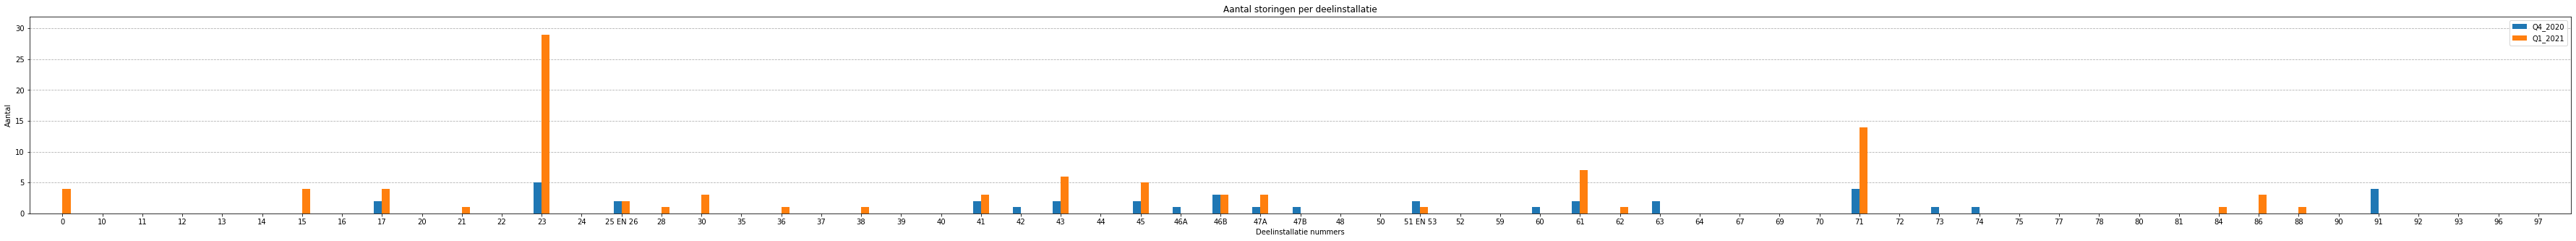

In [174]:
# plot
labels = list(_data.keys())
x = np.arange(len(labels))  # the x locations of the labels

bar_width = 0.2

fig, axis = plt.subplots(figsize=(len(labels), 5))

color_labels = list(source_stage_3.keys())  # names for in legend

# voor het bepalen van de afstand vanaf x zodat de bars niet overlappen
x_generator = (x + (y * (bar_width)) for y in (0, 1))  

# Toevoegen van de bars
for _ in range(len(data)):
    bar = axis.bar(x=next(x_generator), height=data[_], width=bar_width, label=color_labels[_])

# titel en namen van de assen
axis.set_xlabel('Deelinstallatie nummers')
axis.set_ylabel('Aantal')
axis.set_title("Aantal storingen per deelinstallatie")

# namen langs de assen
axis.set_xticks(x + bar_width / len(data))
axis.set_xticklabels(labels)

axis.margins(x=0.01, y=0.1)

axis.set_axisbelow(True)
axis.grid(axis='y', linestyle='--')

axis.legend()

# fig.autofmt_xdate(rotation=45)

plt.show()
add_graph_for_export(fig)

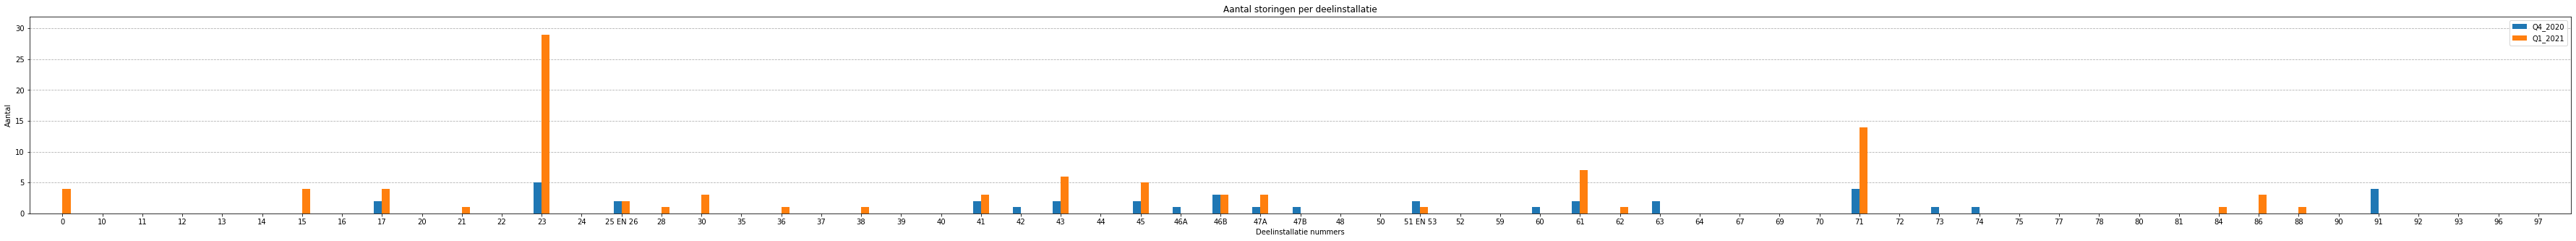

In [187]:
prepped_data = pp.prep(updated_histo_storingen, 
                       time_range=['10-2020', '03-2021'], 
                       available_categories=sa.metadata.contract_info()['aanwezige_deelinstallaties'], 
                       time_key='rapport datum', 
                       category_key='sbs', 
                       bin_size='quarter')

pp.plot(input_data=prepped_data, 
        plot_type='side-by-side', 
        category_labels=sa.metadata.contract_info()['aanwezige_deelinstallaties'], 
        bin_labels=pp.last_seen_bin_names)

{'Q4_2020': 39, 'Q1_2021': 98}


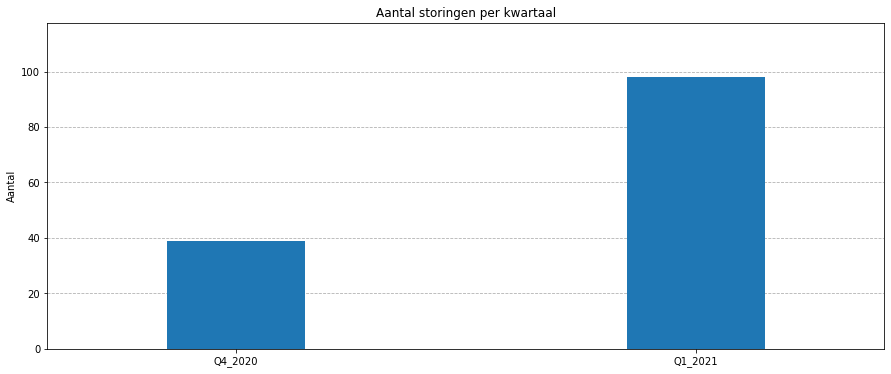

In [175]:
# prep
data = {}

for key in source_stage_2.keys():
    summed_vals = sa.metadata.sum_values(dictionary=source_stage_2[key])
    data[key] = summed_vals

print(data)
    
# plot
fig, axis = plt.subplots(figsize=(15,6))

axis.bar(data.keys(), data.values(), width = 0.3)

axis.set_ylabel('Aantal')
axis.set_title("Aantal storingen per kwartaal")

axis.margins(x=.2, y=.2)

axis.set_axisbelow(True)
axis.grid(axis='y', linestyle='--')

plt.show()
add_graph_for_export(fig)

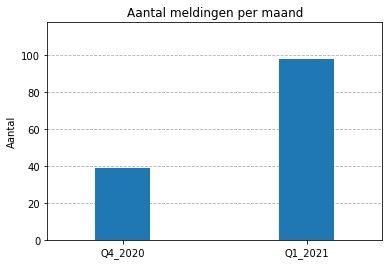

In [189]:
summary_data = pp.prep_summary(updated_histo_storingen, 
                               time_range=['10-2020', '03-2021'], 
                               available_categories=sa.metadata.contract_info()['aanwezige_deelinstallaties'],
                               bin_size='quarter')

pp.plot_summary(input_data=summary_data)

# Verdeling type meldingen per deelinstallatie
Hier wordt er dieper in gegaan op de verschillende typen meldingen van een DI. Welke di wordt meegenomen in deze, wordt bepaalt door een drempelwaarde te specificeren.

NOTE:

Kijk naar de handelingen in het script en of het van belang is om een functie/module te maken voor het samenvoegen van meldingen per di van verschillende maanden. (zodat source_stage_3 of source_stage_4 bereikt wordt)
staging file moet worden gebruikt voor het verder uitwerken van deze grafieken.


In [176]:
df = sa.meldingen.copy()

In [177]:
# unieke types vastlegen
unique_types = df.loc[:, 'type melding (Storing/Incident/Preventief/Onterecht)'].unique()
list(unique_types)

['Preventief', 'Storing', 'Onterecht', 'Incident']

In [178]:
# changing the di_numbers from '45-10' to '45'
new_num = []
for num in df['sbs']:
    if num is np.nan:
        new_num.append(num)
    else:
        new_num.append(sa._isolate_di_number(num))

df.loc[:, 'sbs'] = new_num

In [179]:
sbs_count = df.loc[:, 'sbs'].value_counts()
sbs_count

45          10
41           7
46A          5
74           4
71           2
43           2
67           2
61           2
23           1
62           1
63           1
84           1
86           1
21           1
51 EN 53     1
47A          1
46B          1
Name: sbs, dtype: int64

In [180]:
input_threshhold = widgets.IntSlider(
    value=0,
    min=0,
    max=sbs_count.max(),
    step=1,
    description='Drempelwaarde:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d',
    style=dict(description_width='initial')
)

display(input_threshhold)

IntSlider(value=0, continuous_update=False, description='Drempelwaarde:', max=10, style=SliderStyle(descriptio…

In [181]:
to_process = [x for x in sbs_count.index if sbs_count.at[x] >= input_threshhold.value]
to_process

['45',
 '41',
 '46A',
 '74',
 '71',
 '43',
 '67',
 '61',
 '23',
 '62',
 '63',
 '84',
 '86',
 '21',
 '51 EN 53',
 '47A',
 '46B']

In [182]:
test_grouped = df.copy().groupby(['sbs'])
for group in test_grouped.groups:
    x = test_grouped.get_group(group).to_dict()
print(x.keys())
print(x)

dict_keys(['werkorder', 'status', 'rapport datum', 'month_number', 'werkorder beschrijving', 'asset nummer', 'asset beschrijving', 'sbs', 'sbs omschrijving', 'locatie', 'locatie omschrijving', 'asset nummer 2', 'asset beschrijving 2', 'sbs 2', 'sbs 2 omschrijving', 'locatie 2', 'locatie 2 omschrijving', 'probleem code', 'beschrijving probleem', 'oorzaak code', 'beschrijving oorzaak', 'oplos code', 'oplossing beschrijving', 'uitgevoerde werkzaamheden', 'type melding (Storing/Incident/Preventief/Onterecht)', 'tijdstip monteur ter plaatse', 'streefdatum start', 'geplande start', 'werkelijke start', 'tijdstip einde werkzaamheden', 'tijdstip afmelding', 'tijdstip validatie', 'funcitoneel herstel', 'definitief herstel', 'is financieel nadeel', 'gmblocation3', 'gemeld asset', 'vestiging'])
{'werkorder': {5: 1181891}, 'status': {5: 'SLUIT'}, 'rapport datum': {5: '08-01-18 11:58:00'}, 'month_number': {5: 1}, 'werkorder beschrijving': {5: 'Eigen constatering Redudante Atoom klok defect'}, 'asset

subgroup = {'Onterecht': 1, 'Incident': 1, 'Storing': 1}
subgroup = {'Incident': 2, 'Preventief': 1, 'Storing': 1}
subgroup = {'Onterecht': 2, 'Incident': 1}
ft = {1: {'Preventief': 0, 'Storing': 1, 'Onterecht': 1, 'Incident': 1}, 2: {'Preventief': 1, 'Storing': 1, 'Onterecht': 0, 'Incident': 2}, 3: {'Preventief': 0, 'Storing': 0, 'Onterecht': 2, 'Incident': 1}}
data = [[0, 1, 1, 1], [1, 1, 0, 2], [0, 0, 2, 1]]
['Preventief', 'Storing', 'Onterecht', 'Incident']


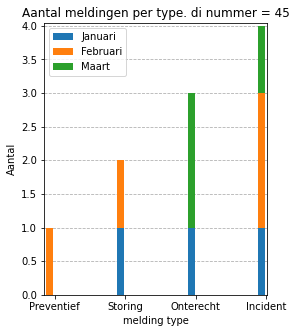

summary_data = 2    4
3    3
1    3
Name: month_number, dtype: int64
ordered_dict = {'Januari': 3, 'Februari': 4, 'Maart': 3}


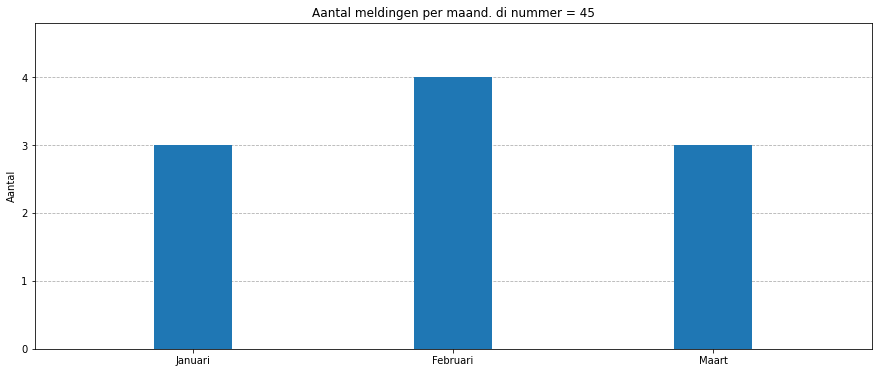

subgroup = {'Storing': 2, 'Onterecht': 1, 'Incident': 1}
subgroup = {'Onterecht': 1, 'Preventief': 1}
subgroup = {'Preventief': 1}
ft = {1: {'Preventief': 0, 'Storing': 2, 'Onterecht': 1, 'Incident': 1}, 2: {'Preventief': 1, 'Storing': 0, 'Onterecht': 1, 'Incident': 0}, 3: {'Preventief': 1, 'Storing': 0, 'Onterecht': 0, 'Incident': 0}}
data = [[0, 2, 1, 1], [1, 0, 1, 0], [1, 0, 0, 0]]
['Preventief', 'Storing', 'Onterecht', 'Incident']


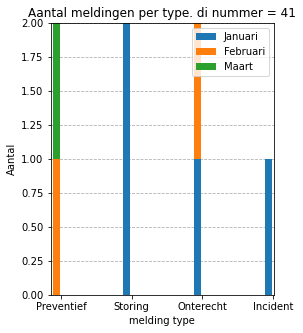

summary_data = 1    4
2    2
3    1
Name: month_number, dtype: int64
ordered_dict = {'Januari': 4, 'Februari': 2, 'Maart': 1}


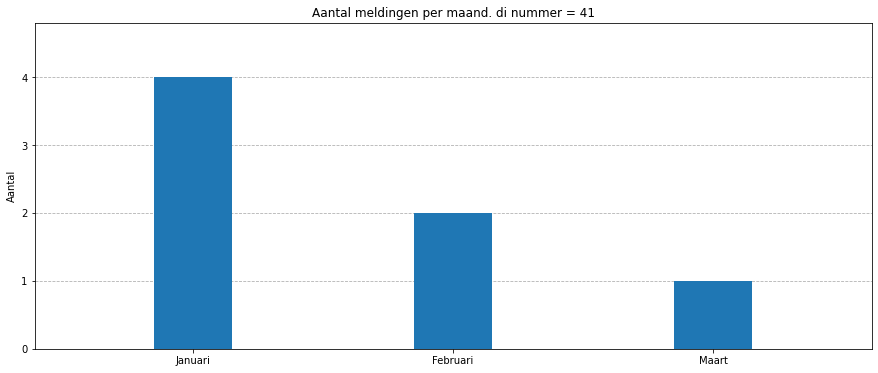

subgroup = {'Onterecht': 2, 'Incident': 1, 'Preventief': 1}
subgroup = {'Preventief': 1}
ft = {2: {'Preventief': 1, 'Storing': 0, 'Onterecht': 2, 'Incident': 1}, 3: {'Preventief': 1, 'Storing': 0, 'Onterecht': 0, 'Incident': 0}}
data = [[0, 0, 0, 0], [1, 0, 2, 1], [1, 0, 0, 0]]
['Preventief', 'Storing', 'Onterecht', 'Incident']


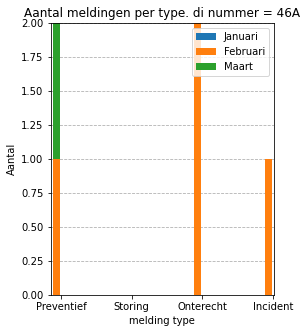

summary_data = 2    4
3    1
Name: month_number, dtype: int64
ordered_dict = {'Februari': 4, 'Maart': 1}


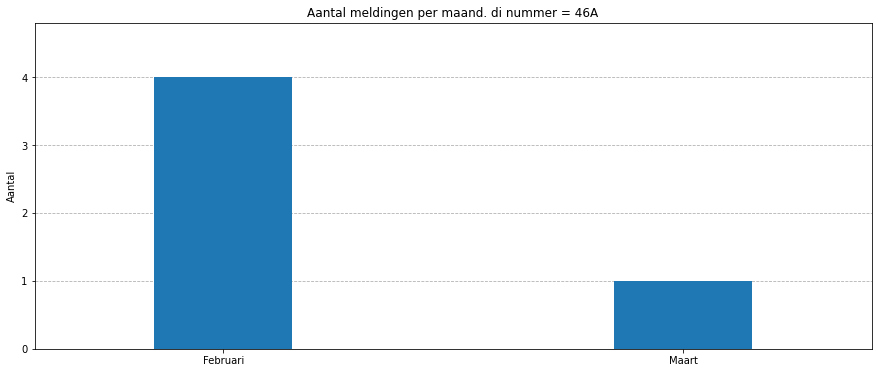

subgroup = {'Storing': 2, 'Preventief': 1}
subgroup = {'Preventief': 1}
ft = {2: {'Preventief': 1, 'Storing': 2, 'Onterecht': 0, 'Incident': 0}, 3: {'Preventief': 1, 'Storing': 0, 'Onterecht': 0, 'Incident': 0}}
data = [[0, 0, 0, 0], [1, 2, 0, 0], [1, 0, 0, 0]]
['Preventief', 'Storing', 'Onterecht', 'Incident']


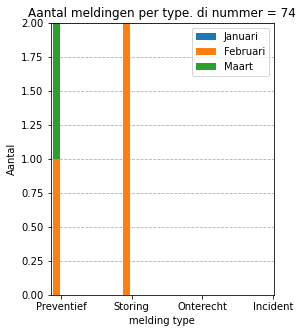

summary_data = 2    3
3    1
Name: month_number, dtype: int64
ordered_dict = {'Februari': 3, 'Maart': 1}


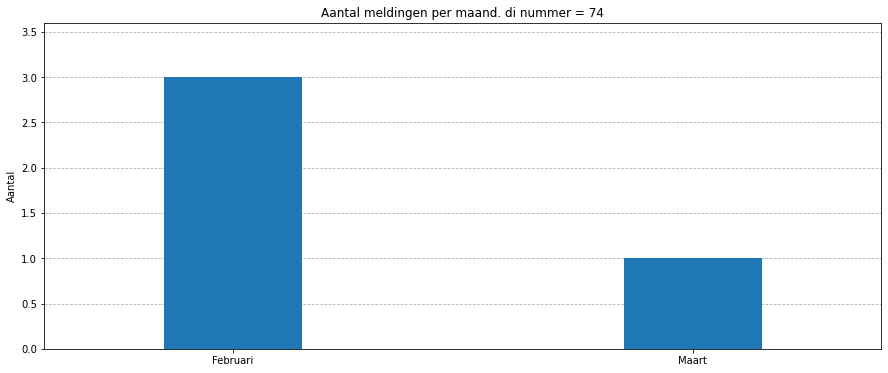

subgroup = {'Storing': 1}
subgroup = {'Onterecht': 1}
ft = {1: {'Preventief': 0, 'Storing': 1, 'Onterecht': 0, 'Incident': 0}, 2: {'Preventief': 0, 'Storing': 0, 'Onterecht': 1, 'Incident': 0}}
data = [[0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 0]]
['Preventief', 'Storing', 'Onterecht', 'Incident']


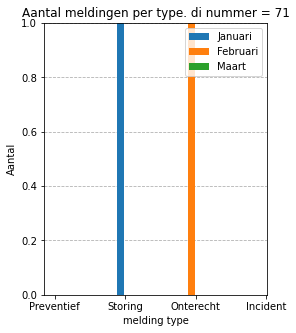

summary_data = 2    1
1    1
Name: month_number, dtype: int64
ordered_dict = {'Januari': 1, 'Februari': 1}


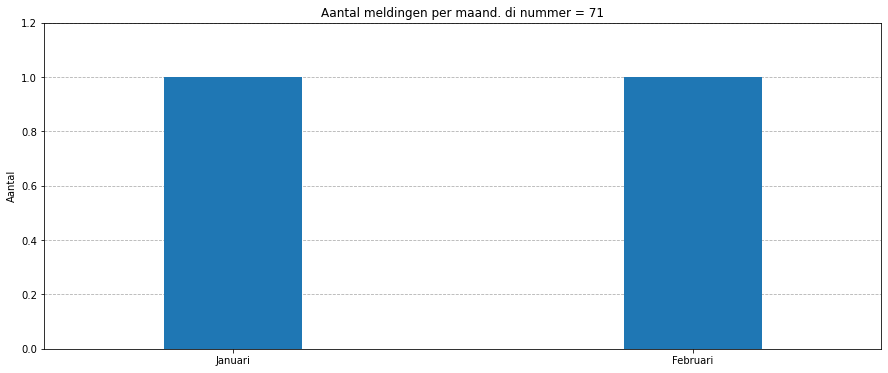

subgroup = {'Incident': 1}
subgroup = {'Onterecht': 1}
ft = {2: {'Preventief': 0, 'Storing': 0, 'Onterecht': 0, 'Incident': 1}, 3: {'Preventief': 0, 'Storing': 0, 'Onterecht': 1, 'Incident': 0}}
data = [[0, 0, 0, 0], [0, 0, 0, 1], [0, 0, 1, 0]]
['Preventief', 'Storing', 'Onterecht', 'Incident']


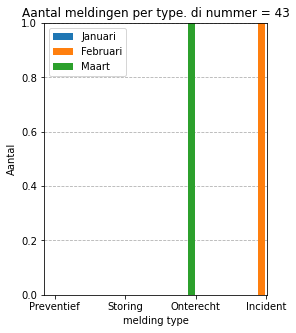

summary_data = 3    1
2    1
Name: month_number, dtype: int64
ordered_dict = {'Februari': 1, 'Maart': 1}


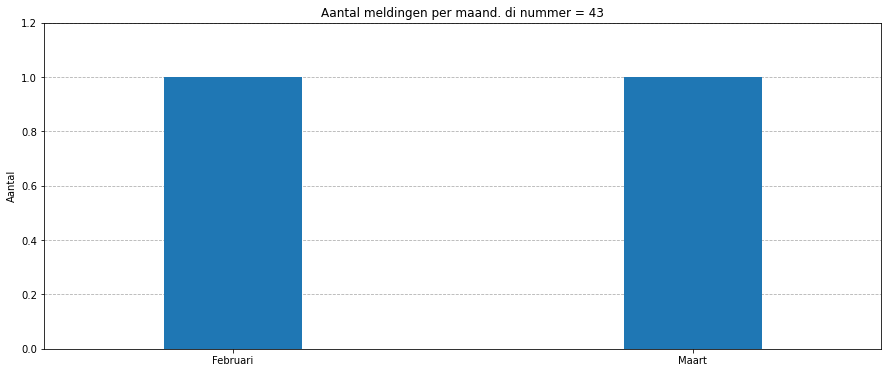

subgroup = {'Incident': 1, 'Preventief': 1}
ft = {2: {'Preventief': 1, 'Storing': 0, 'Onterecht': 0, 'Incident': 1}}
data = [[0, 0, 0, 0], [1, 0, 0, 1], [0, 0, 0, 0]]
['Preventief', 'Storing', 'Onterecht', 'Incident']


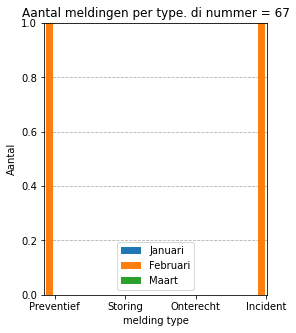

summary_data = 2    2
Name: month_number, dtype: int64
ordered_dict = {'Februari': 2}


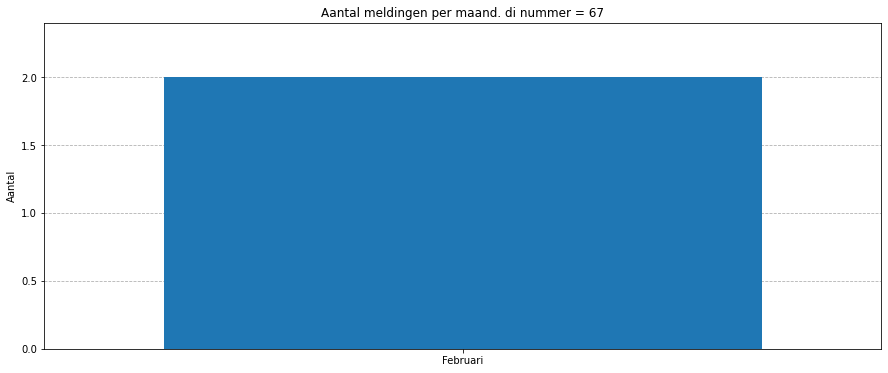

subgroup = {'Preventief': 1}
subgroup = {'Onterecht': 1}
ft = {1: {'Preventief': 1, 'Storing': 0, 'Onterecht': 0, 'Incident': 0}, 3: {'Preventief': 0, 'Storing': 0, 'Onterecht': 1, 'Incident': 0}}
data = [[1, 0, 0, 0], [0, 0, 0, 0], [0, 0, 1, 0]]
['Preventief', 'Storing', 'Onterecht', 'Incident']


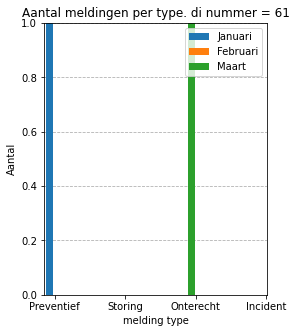

summary_data = 3    1
1    1
Name: month_number, dtype: int64
ordered_dict = {'Januari': 1, 'Maart': 1}


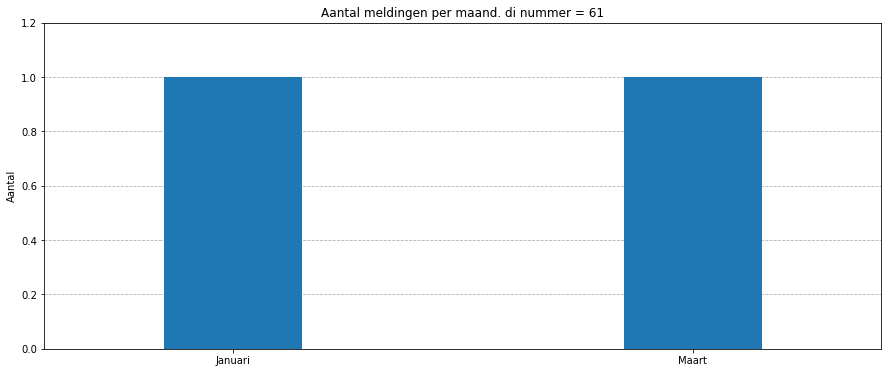

subgroup = {'Storing': 1}
ft = {1: {'Preventief': 0, 'Storing': 1, 'Onterecht': 0, 'Incident': 0}}
data = [[0, 1, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0]]
['Preventief', 'Storing', 'Onterecht', 'Incident']


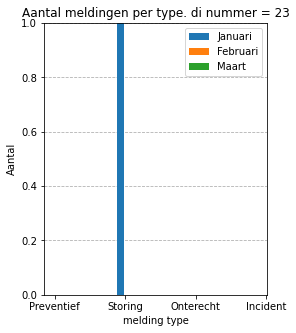

summary_data = 1    1
Name: month_number, dtype: int64
ordered_dict = {'Januari': 1}


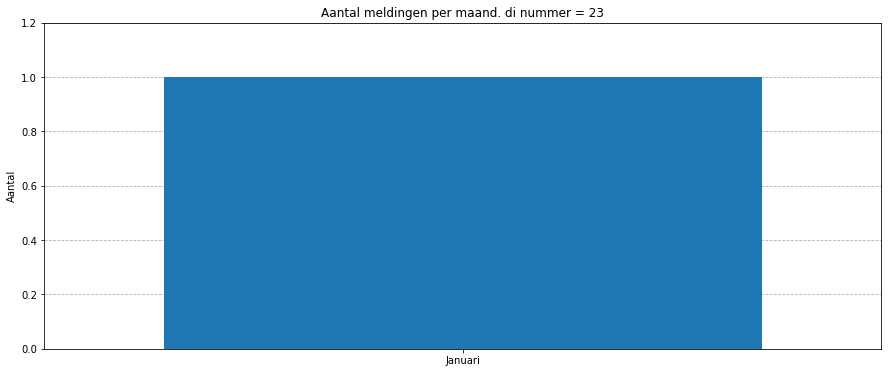

subgroup = {'Incident': 1}
ft = {1: {'Preventief': 0, 'Storing': 0, 'Onterecht': 0, 'Incident': 1}}
data = [[0, 0, 0, 1], [0, 0, 0, 0], [0, 0, 0, 0]]
['Preventief', 'Storing', 'Onterecht', 'Incident']


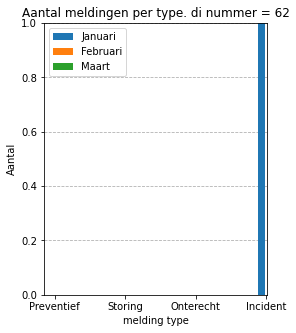

summary_data = 1    1
Name: month_number, dtype: int64
ordered_dict = {'Januari': 1}


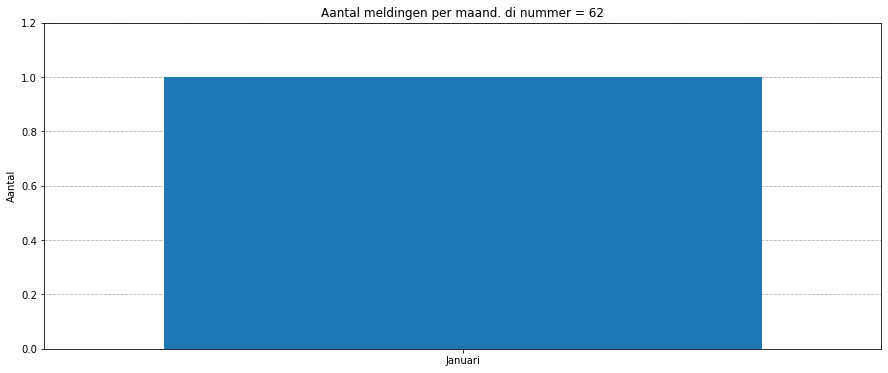

subgroup = {'Storing': 1}
ft = {1: {'Preventief': 0, 'Storing': 1, 'Onterecht': 0, 'Incident': 0}}
data = [[0, 1, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0]]
['Preventief', 'Storing', 'Onterecht', 'Incident']


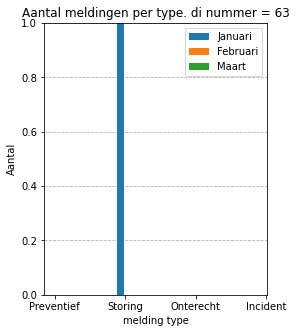

summary_data = 1    1
Name: month_number, dtype: int64
ordered_dict = {'Januari': 1}


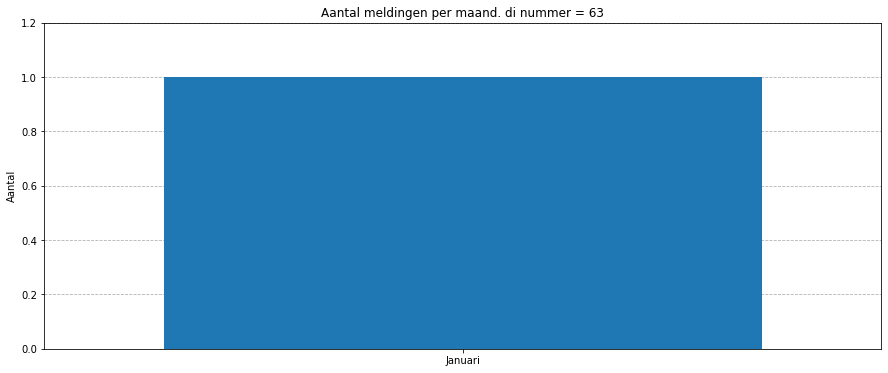

subgroup = {'Onterecht': 1}
ft = {3: {'Preventief': 0, 'Storing': 0, 'Onterecht': 1, 'Incident': 0}}
data = [[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 1, 0]]
['Preventief', 'Storing', 'Onterecht', 'Incident']


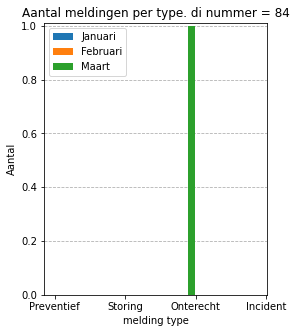

summary_data = 3    1
Name: month_number, dtype: int64
ordered_dict = {'Maart': 1}


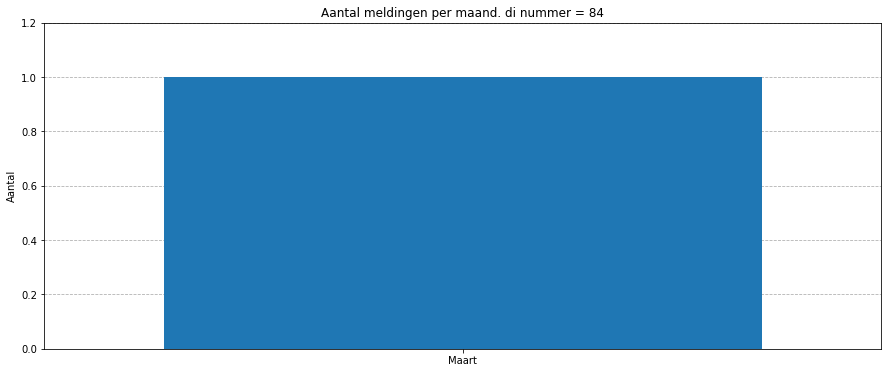

subgroup = {'Incident': 1}
ft = {1: {'Preventief': 0, 'Storing': 0, 'Onterecht': 0, 'Incident': 1}}
data = [[0, 0, 0, 1], [0, 0, 0, 0], [0, 0, 0, 0]]
['Preventief', 'Storing', 'Onterecht', 'Incident']


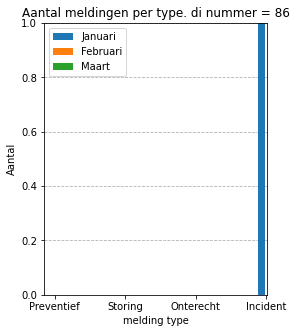

summary_data = 1    1
Name: month_number, dtype: int64
ordered_dict = {'Januari': 1}


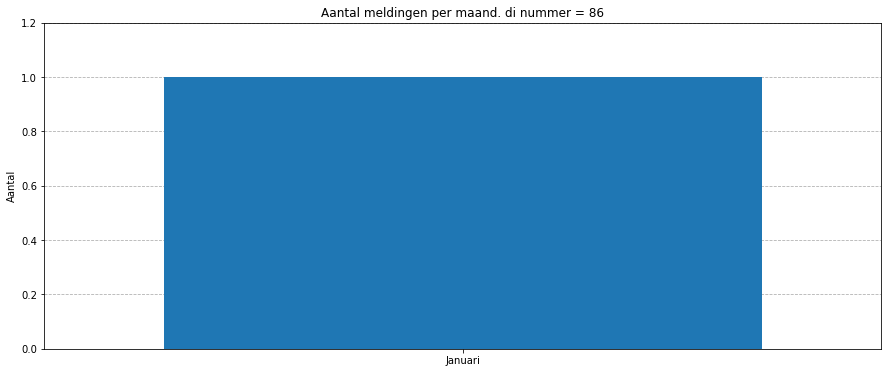

subgroup = {'Preventief': 1}
ft = {1: {'Preventief': 1, 'Storing': 0, 'Onterecht': 0, 'Incident': 0}}
data = [[1, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0]]
['Preventief', 'Storing', 'Onterecht', 'Incident']


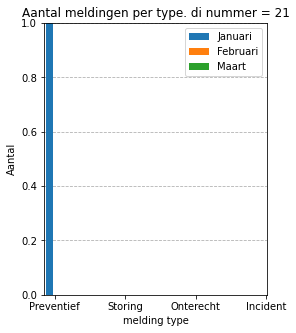

summary_data = 1    1
Name: month_number, dtype: int64
ordered_dict = {'Januari': 1}


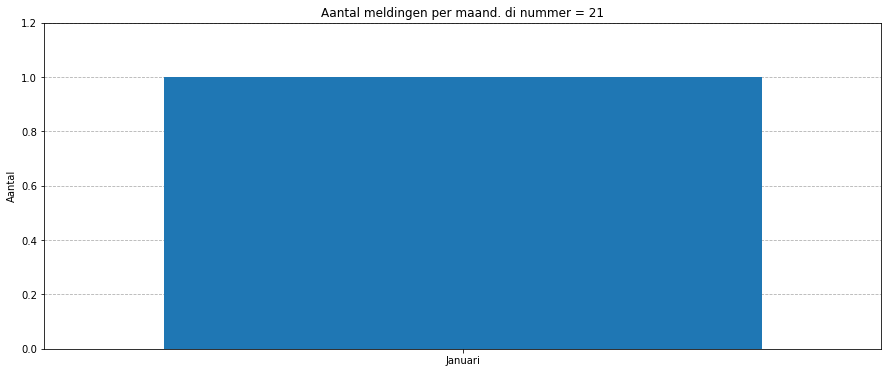

subgroup = {'Onterecht': 1}
ft = {3: {'Preventief': 0, 'Storing': 0, 'Onterecht': 1, 'Incident': 0}}
data = [[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 1, 0]]
['Preventief', 'Storing', 'Onterecht', 'Incident']


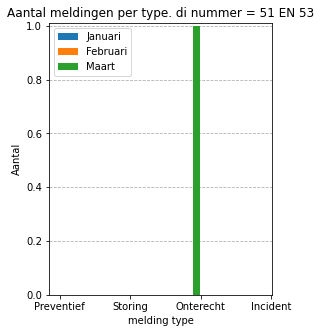

summary_data = 3    1
Name: month_number, dtype: int64
ordered_dict = {'Maart': 1}


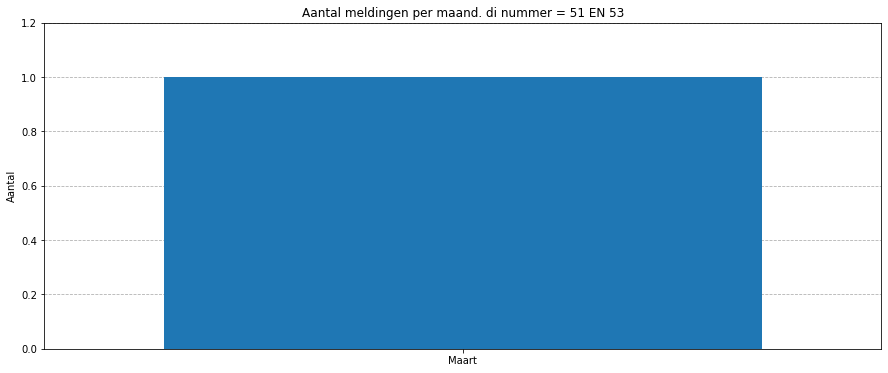

subgroup = {'Onterecht': 1}
ft = {1: {'Preventief': 0, 'Storing': 0, 'Onterecht': 1, 'Incident': 0}}
data = [[0, 0, 1, 0], [0, 0, 0, 0], [0, 0, 0, 0]]
['Preventief', 'Storing', 'Onterecht', 'Incident']


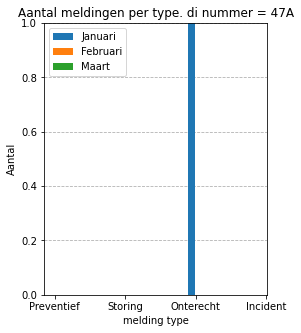

summary_data = 1    1
Name: month_number, dtype: int64
ordered_dict = {'Januari': 1}


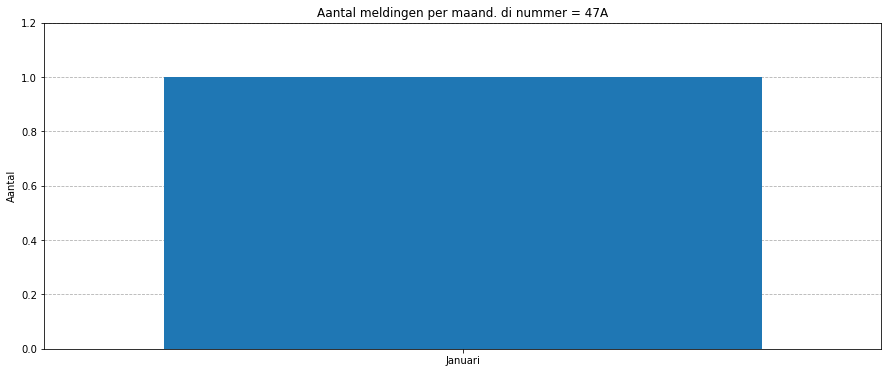

subgroup = {'Incident': 1}
ft = {2: {'Preventief': 0, 'Storing': 0, 'Onterecht': 0, 'Incident': 1}}
data = [[0, 0, 0, 0], [0, 0, 0, 1], [0, 0, 0, 0]]
['Preventief', 'Storing', 'Onterecht', 'Incident']


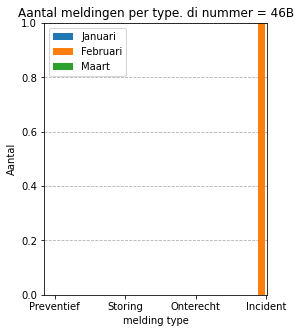

summary_data = 2    1
Name: month_number, dtype: int64
ordered_dict = {'Februari': 1}


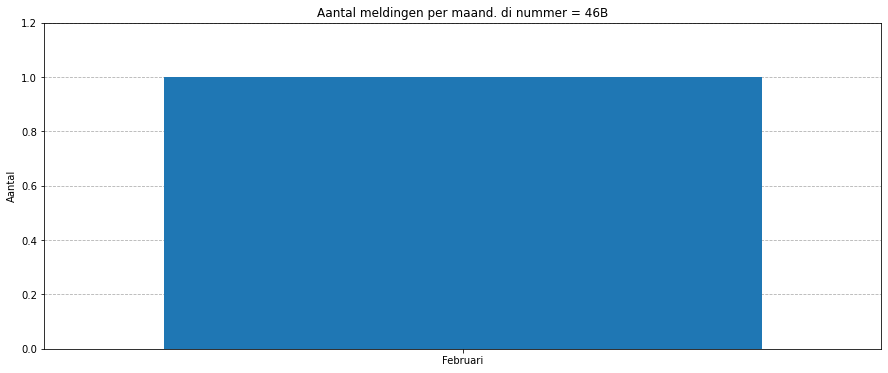

In [183]:
df_group_sbs = df.groupby(['sbs'])

# cols kan voor een sandbox tool variabel gemaakt worden.
cols = ['type melding (Storing/Incident/Preventief/Onterecht)', 'month_number']


for i in to_process:
    ft = {}
    
    current_di_num = i
    
    group = df_group_sbs.get_group(i)[cols]
    
    lvl2_group = group.groupby(['month_number'])
    
    for g in lvl2_group.groups:
        ft[g] = {key: 0 for key in unique_types}

        subgroup = dict(lvl2_group.get_group(g)['type melding (Storing/Incident/Preventief/Onterecht)'].value_counts())
        
        print(f'subgroup = {subgroup}')
        
        for key, value in subgroup.items():
            ft[g][key] += value
        
    print(f'ft = {ft}')
    
    #
    # prep data for first grash (stacked bar)
    data = []

    for i in range(3):
        n = i + 1
        if n in ft.keys():
            data.append(list(ft[n].values()))
        else:
            data.append([0 for _ in range(len(unique_types))])

    print(f'data = {data}')
    
    #
    # plotting stacked bar
    labels = list(unique_types)
    print(labels)
    
    x = np.arange(len(labels))  # the x locations of the labels

    bar_width = 0.2

    fig, axis = plt.subplots(figsize=(len(labels), 5))

    color_labels = list(ft.keys())  # names for in legend

    # voor het bepalen van de afstand vanaf x zodat de bars niet overlappen
    x_generator = (x + (y * (bar_width)) for y in (0, 1))  

    # Toevoegen van de bars  
    prev = []
    for line in range(len(data)):
        month = sa._month_num_to_name([line+1])  # index (line) = 0  =>  month = 1, and so on

        # added case for loop l = 0 after if
        axis.bar(labels, data[line], width, label=month, bottom=prev) if line > 0 else \
        axis.bar(labels, data[line], width, label=month)

        # prev sets the height of the newly added values like above
        # the added list needs to be added to prev to get the correct height
        prev = [prev[idx] + data[line][idx] for idx in range(len(data[line]))] if line > 0 else data[line]

    # titel en namen van de assen
    axis.set_xlabel('melding type')
    axis.set_ylabel('Aantal')
    axis.set_title(f"Aantal meldingen per type. di nummer = {current_di_num}")

    # namen langs de assen
    axis.set_xticks(x + bar_width / len(data))
    axis.set_xticklabels(labels)

    axis.margins(x=0.01, y=0.01)

    axis.set_axisbelow(True)
    axis.grid(axis='y', linestyle='--')

    axis.legend()

    # fig.autofmt_xdate(rotation=45)

    plt.show()
    add_graph_for_export(fig)
    
    #
    # prepping summary graph
    summary_data = group['month_number'].value_counts()
    
    print(f'summary_data = {summary_data}')

    ordered_dict = {key: summary_data[key] for key in sorted(summary_data.to_dict())}
    
    # onderstaande werkt niet meer na een aantal iteraties
#     for key in ordered_dict.keys():
#         new_key = sa._month_num_to_name([key])
#         ordered_dict[new_key] = ordered_dict.pop(key)
    
    _ordered_dict = {}
    for key in ordered_dict.keys():
        new_key = sa._month_num_to_name([key])
        _ordered_dict[new_key] = ordered_dict[key]
    
    del ordered_dict
    ordered_dict = _ordered_dict
    del _ordered_dict
    
    print(f'ordered_dict = {ordered_dict}')
    
    #
    # plotting summary graph
    fig, axis = plt.subplots(figsize=(15,6))

    axis.bar(ordered_dict.keys(), ordered_dict.values(), width = 0.3)

    axis.set_ylabel('Aantal')
    axis.set_title(f"Aantal meldingen per maand. di nummer = {current_di_num}")

    axis.margins(x=.2, y=.2)

    axis.set_axisbelow(True)
    axis.grid(axis='y', linestyle='--')

    plt.show()
    add_graph_for_export(fig)

# PDF export
file wordt geopend

per grafiek die gemaakt wordt moet het volgende toegevoegd worden aan de code cell.
```
plt.savefig(pp, format='pdf')
```

of 

```
pp.savefig()
```

Om aan het eind van dit notebook de pdf te sluiten met:
```
pp.close()
```

In [184]:
from matplotlib.backends.backend_pdf import PdfPages
pdfp= PdfPages('test_graph_export.pdf')
for graph in graphs:
    pdfp.savefig(graph)
pdfp.close()